In [1]:
#  essential libraries for data manipulation and analysis
import pandas as pd
import numpy as np

#  libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#  libraries for statistical analysis
from scipy.stats import norm
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

#  libraries for preprocessing and model building
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder, PowerTransformer, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.feature_selection import mutual_info_regression, SelectKBest, SelectKBest, f_regression, RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from typing import Dict, Any, List, Tuple
import shap
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline


# Partial dependence plots for features
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
from sklearn.impute import SimpleImputer

# libraries for model evaluation
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score, silhouette_score, mean_absolute_error
from sklearn.inspection import permutation_importance 
from xgboost import XGBRegressor

c:\Users\R250\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Importing and Cleaning the dataset 

In [2]:
#importing the data
df = pd.read_csv('marketing_campaign_dataset.csv')

#column names
df_column_headers = df.keys()

# Removing the ',' and '$' symbols from Acquistion Cost coloumn 
df['Acquisition_Cost ($)'] = df['Acquisition_Cost ($)'].str.replace('$', '').str.replace(',', '').astype(float)

# Removing the 'days' from the duration coloumn
df['Duration'] = df['Duration'].str.replace('days','').astype(int)

#converting date column to datetime
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y")

# dropping Campaign ID
df = df.drop(columns='Campaign_ID') 

#finding missing data
print(f'Missing Data: {df.isna().sum()}')
print(f'Dataset Shape: {df.shape}')

# converting the categorical data as such
categorical_columns = ['Company', 'Campaign_Type', 'Target_Audience', 'Channel_Used', 'Location', 'Language', 'Customer_Segment']
for col in categorical_columns:
    df[col] = df[col].astype('category')


Missing Data: Company                 0
Campaign_Type           0
Target_Audience         0
Duration                0
Channel_Used            0
Conversion_Rate         0
Acquisition_Cost ($)    0
ROI                     0
Location                0
Language                0
Clicks                  0
Impressions             0
Engagement_Score        0
Customer_Segment        0
Date                    0
dtype: int64
Dataset Shape: (200000, 15)


#### Feature Generation

In [3]:
def generate_basic_features(df: pd.DataFrame) -> pd.DataFrame:
    """Generate basic features from the dataset."""
    df['Cost_per_Click'] = df['Acquisition_Cost ($)'].div(df['Clicks']).replace([np.inf, -np.inf], np.nan)
    df['Click_Through_Rate'] = df['Clicks'].div(df['Impressions']).replace([np.inf, -np.inf], np.nan)
    df['Cost_per_Acquisition'] = df['Acquisition_Cost ($)'].div(df['Conversion_Rate']).round(3).replace([np.inf, -np.inf], np.nan)
    return df

def generate_time_features(df: pd.DataFrame) -> pd.DataFrame:
    """Generate time-related features."""
    df['Month'] = df['Date'].dt.month
    df['Day_of_Week'] = df['Date'].dt.dayofweek
    df['Campaign_Start'] = df.groupby('Campaign_Type')['Date'].transform('min')
    df['Days_Since_Campaign_Start'] = (df['Date'] - df['Campaign_Start']).dt.days
    return df

def generate_audience_features(df: pd.DataFrame) -> pd.DataFrame:
    """Generate audience-related features."""
    df['Cumulative_Impressions_Per_Audience'] = df.groupby('Target_Audience')['Impressions'].cumsum()
    df['Historical_Audience_Engagement'] = df.groupby('Target_Audience')['Engagement_Score'].transform(
        lambda x: x.expanding().mean().shift()
    ).fillna(0)
    return df

def generate_channel_features(df: pd.DataFrame) -> pd.DataFrame:
    """Generate channel-related features."""
    df['Company_Channel_Experience'] = df.groupby(['Company', 'Channel_Used']).cumcount() + 1
    df['Channel_Usage_Intensity'] = df.groupby(['Channel_Used', 'Date'])['Campaign_Type'].transform('count')
    return df

def generate_campaign_features(df: pd.DataFrame) -> pd.DataFrame:
    """Generate campaign-related features."""
    df['Daily_Spend'] = df['Acquisition_Cost ($)'].div(df['Duration'])
    return df

def generate_financial_features(df: pd.DataFrame) -> pd.DataFrame:
    """Generate financial-related features."""
    df['Cost_per_Lead'] = df['Acquisition_Cost ($)'].div(df['Clicks']).replace([np.inf, -np.inf], np.nan)
    df['Return_on_Ad_Spend'] = df['ROI'].div(100).add(1)
    df['Estimated_Total_Revenue'] = df['Acquisition_Cost ($)'] * (1 + df['ROI'])
    df['Estimated_Average_Order_Value'] = df['Estimated_Total_Revenue'].div(df['Conversion_Rate'] * df['Clicks']).replace([np.inf, -np.inf], np.nan)
    df['Customer_Lifetime_Value'] = df['Estimated_Average_Order_Value'] * 3
    return df

def generate_features(df: pd.DataFrame, config: Dict[str, Any]) -> pd.DataFrame:
    """
    Generate features for the marketing campaign dataset.
    
    Args:
    df (pd.DataFrame): Input DataFrame
    config (Dict[str, Any]): Configuration dictionary for feature generation
    
    Returns:
    pd.DataFrame: DataFrame with generated features
    """
    df = df.copy()  # Create a copy to avoid modifying the original DataFrame
    
    # Ensure 'Date' is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Generate features
    df = generate_basic_features(df)
    df = generate_time_features(df)
    df = generate_audience_features(df)
    df = generate_channel_features(df)
    df = generate_campaign_features(df)
    df = generate_financial_features(df)
    
    # Bin Duration
    df['Duration_Category'] = pd.cut(
        df['Duration'],
        bins=config['duration_bins'],
        labels=config['duration_labels']
    )
    
    return df

# Configuration dictionary
config = {
    'duration_bins': [0, 15, 30, 60, float('inf')],
    'duration_labels': ['Very Short', 'Short', 'Medium', 'Long']
}

# Generate features
df = generate_features(df, config)
print("Generated features:")
print(df.columns)

Generated features:
Index(['Company', 'Campaign_Type', 'Target_Audience', 'Duration',
       'Channel_Used', 'Conversion_Rate', 'Acquisition_Cost ($)', 'ROI',
       'Location', 'Language', 'Clicks', 'Impressions', 'Engagement_Score',
       'Customer_Segment', 'Date', 'Cost_per_Click', 'Click_Through_Rate',
       'Cost_per_Acquisition', 'Month', 'Day_of_Week', 'Campaign_Start',
       'Days_Since_Campaign_Start', 'Cumulative_Impressions_Per_Audience',
       'Historical_Audience_Engagement', 'Company_Channel_Experience',
       'Channel_Usage_Intensity', 'Daily_Spend', 'Cost_per_Lead',
       'Return_on_Ad_Spend', 'Estimated_Total_Revenue',
       'Estimated_Average_Order_Value', 'Customer_Lifetime_Value',
       'Duration_Category'],
      dtype='object')


C:\Users\R250\AppData\Local\Temp\ipykernel_15444\1838464621.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['Campaign_Start'] = df.groupby('Campaign_Type')['Date'].transform('min')
C:\Users\R250\AppData\Local\Temp\ipykernel_15444\1838464621.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['Cumulative_Impressions_Per_Audience'] = df.groupby('Target_Audience')['Impressions'].cumsum()
C:\Users\R250\AppData\Local\Temp\ipykernel_15444\1838464621.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain c


#### Cleaning up the new features

Skewness of Cost_per_Click: 2.2092617808936215
Skewness of Click_Through_Rate: 2.315530374777656
Skewness of Cost_per_Acquisition: 3.224504669554588
Skewness of Month: -0.010383861129140503
Skewness of Day_of_Week: -0.0037807049381671314
Skewness of Days_Since_Campaign_Start: 5.08057562857159e-05
Skewness of Cumulative_Impressions_Per_Audience: 0.0007557863101752203
Skewness of Historical_Audience_Engagement: -29.11424300943986
Skewness of Company_Channel_Experience: 0.0019494816937169505
Skewness of Channel_Usage_Intensity: 0.12585864827954327
Skewness of Daily_Spend: 1.3311025796116553
Skewness of Cost_per_Lead: 2.2092617808936215
Skewness of Return_on_Ad_Spend: -0.005043390809769757
Skewness of Estimated_Total_Revenue: 0.6094453958436681
Skewness of Estimated_Average_Order_Value: 6.54055818557435
Skewness of Customer_Lifetime_Value: 6.54055818557435


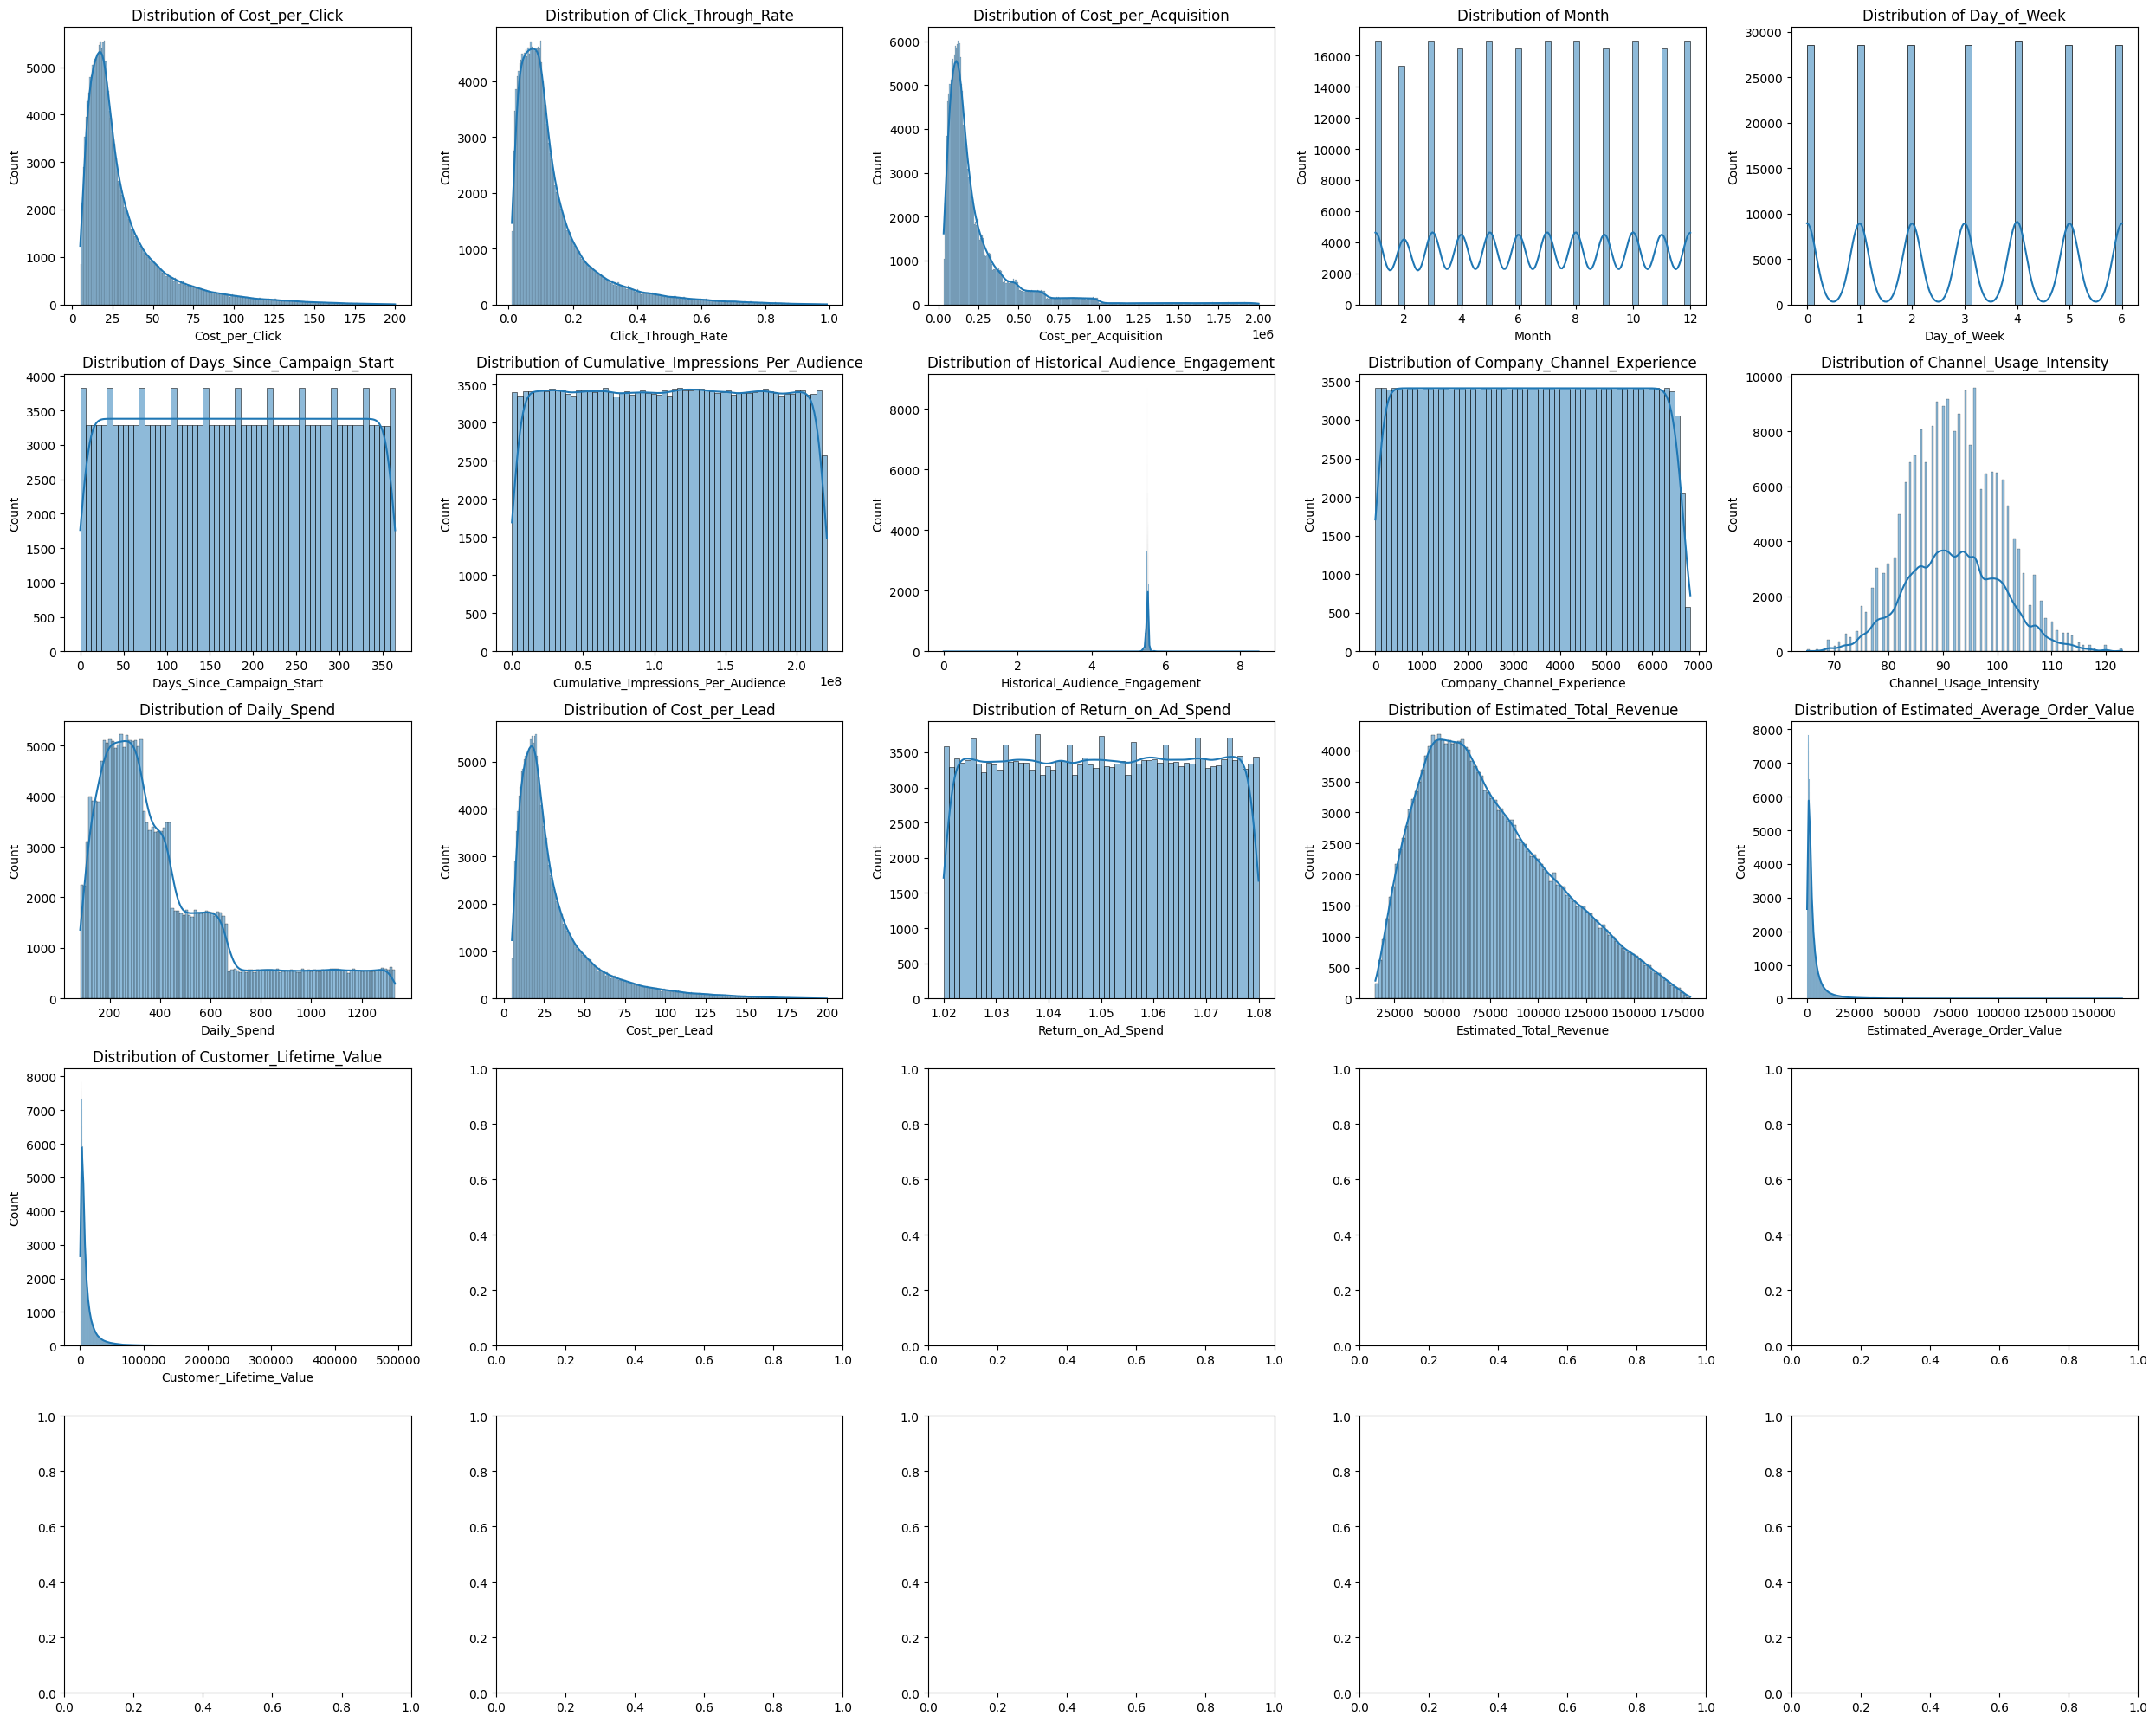

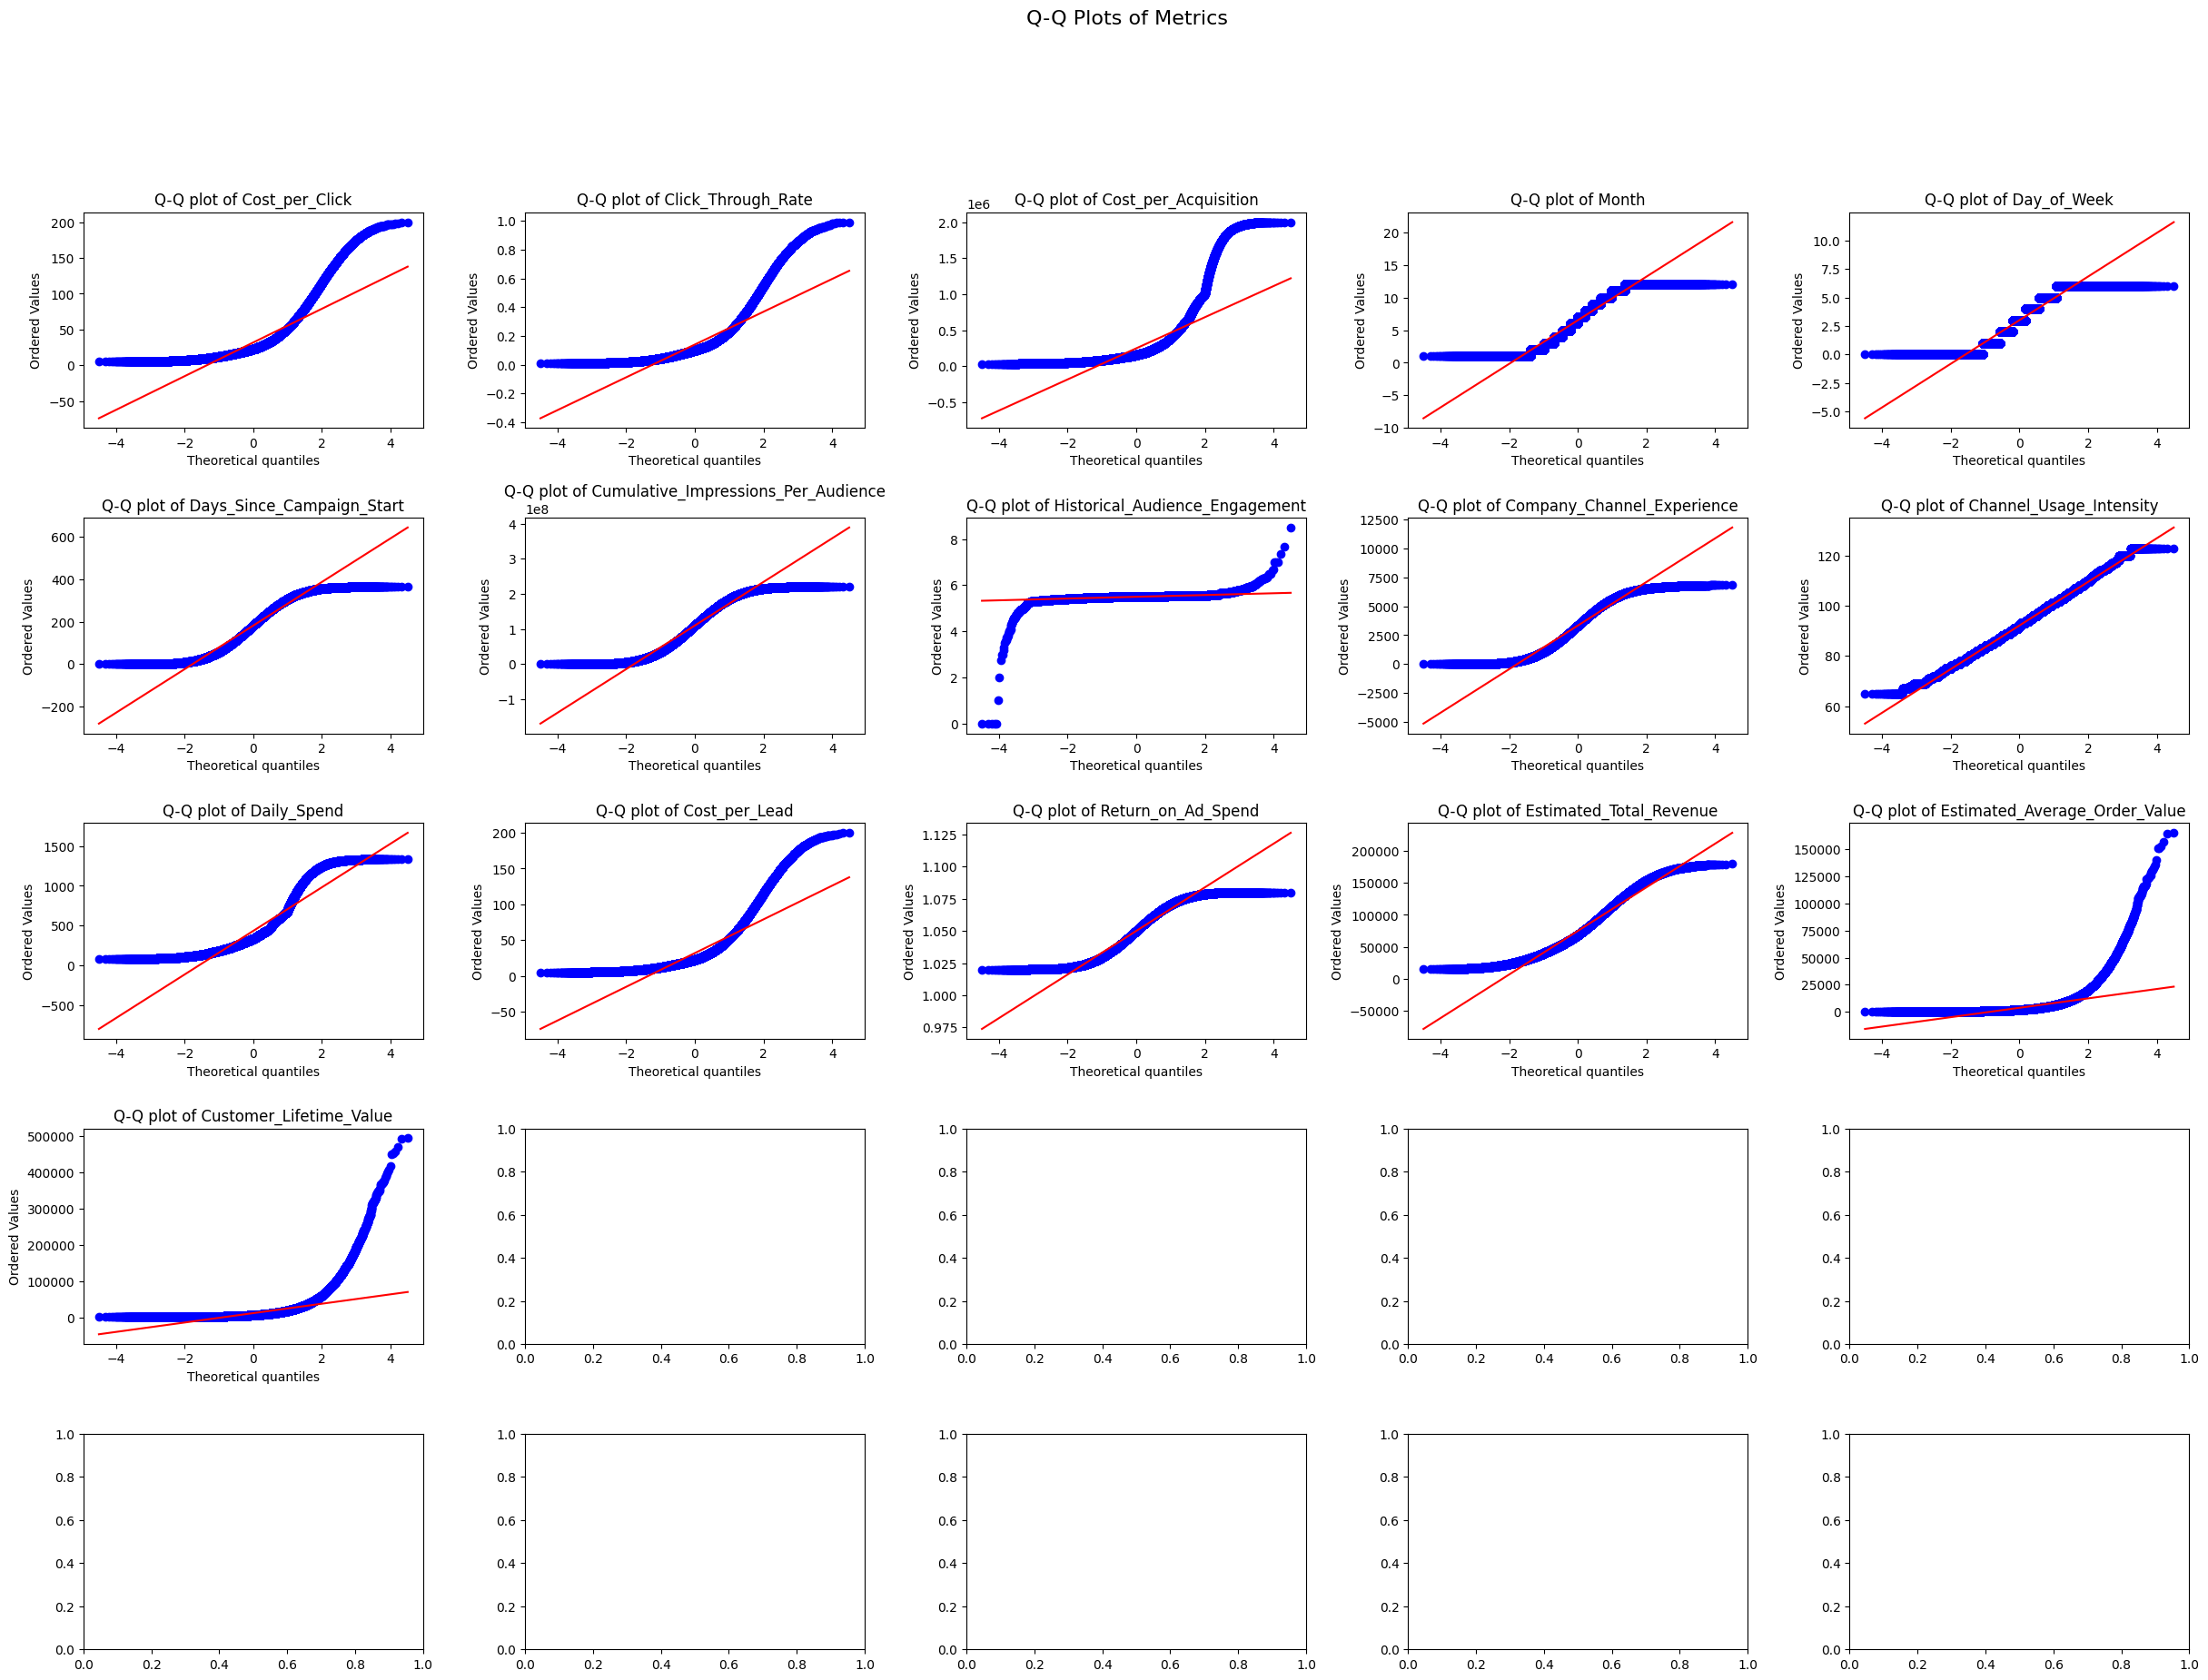

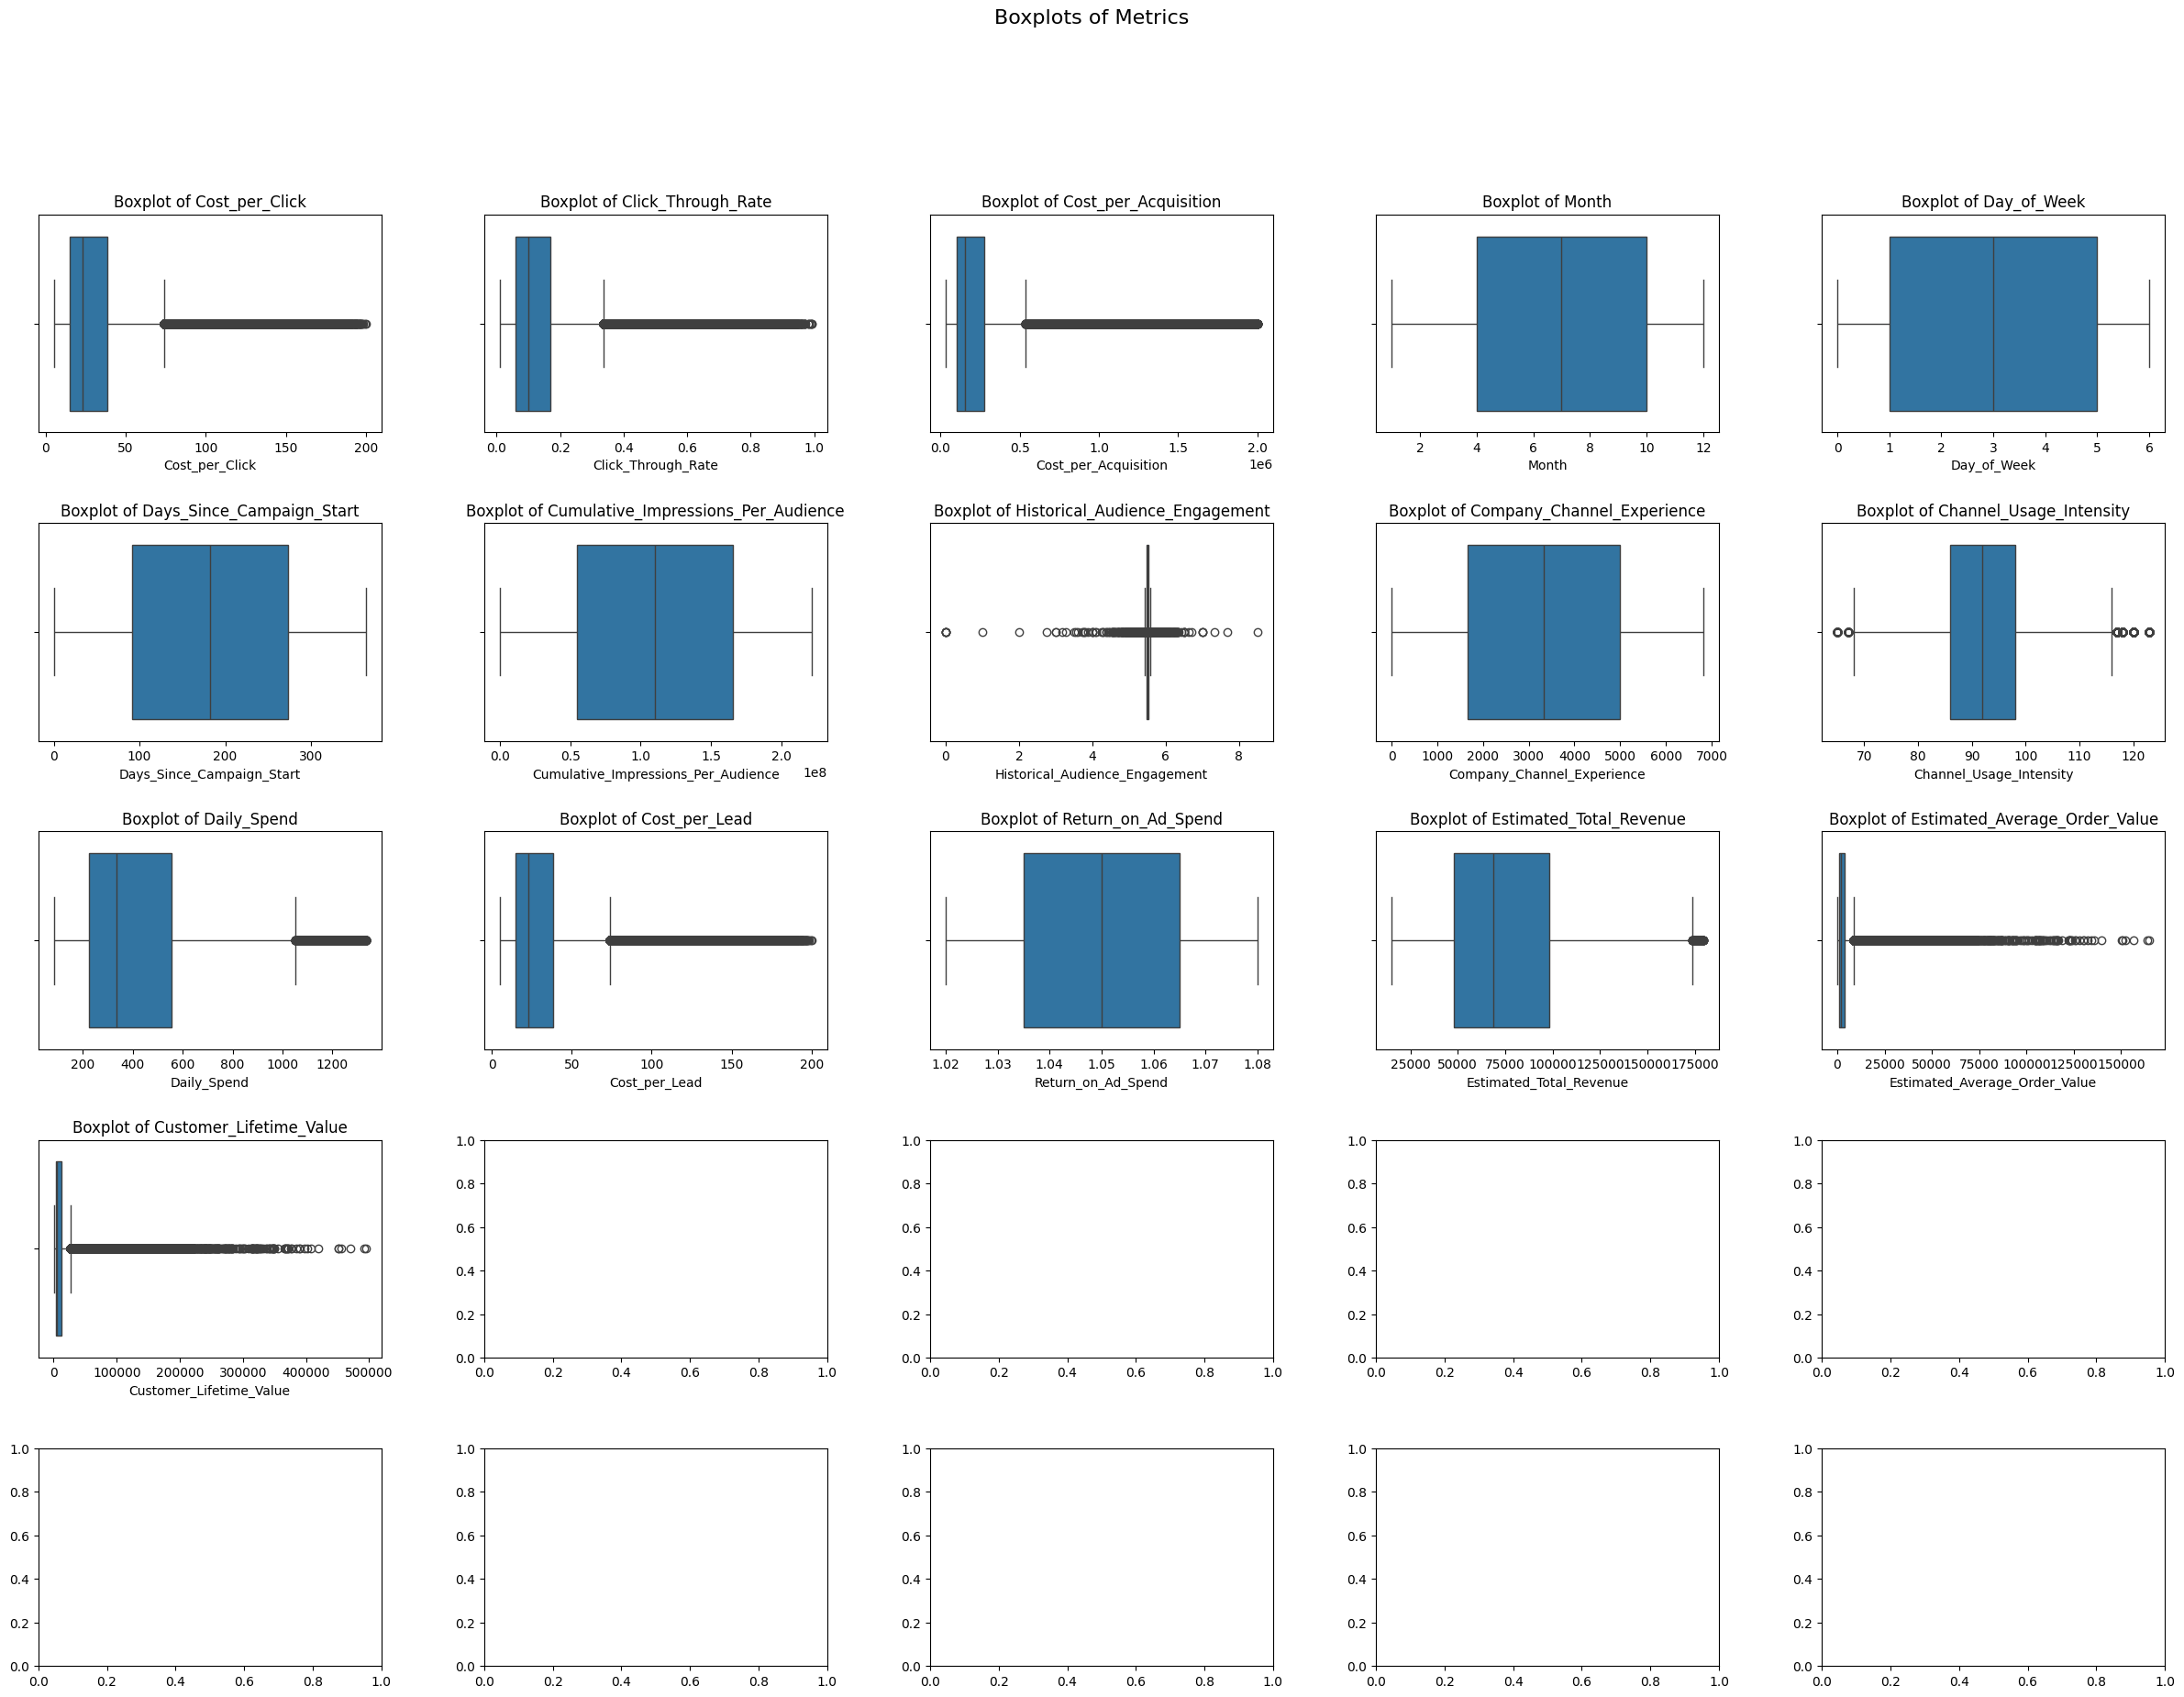


Number of Cost_per_Click outliers: 0
Percentage of Cost_per_Click outliers: 0.00%

Number of Click_Through_Rate outliers: 0
Percentage of Click_Through_Rate outliers: 0.00%

Number of Cost_per_Acquisition outliers: 724
Percentage of Cost_per_Acquisition outliers: 0.36%

Number of Month outliers: 0
Percentage of Month outliers: 0.00%

Number of Day_of_Week outliers: 0
Percentage of Day_of_Week outliers: 0.00%

Number of Days_Since_Campaign_Start outliers: 0
Percentage of Days_Since_Campaign_Start outliers: 0.00%

Number of Cumulative_Impressions_Per_Audience outliers: 0
Percentage of Cumulative_Impressions_Per_Audience outliers: 0.00%

Number of Historical_Audience_Engagement outliers: 842
Percentage of Historical_Audience_Engagement outliers: 0.42%

Number of Company_Channel_Experience outliers: 0
Percentage of Company_Channel_Experience outliers: 0.00%

Number of Channel_Usage_Intensity outliers: 0
Percentage of Channel_Usage_Intensity outliers: 0.00%

Number of Daily_Spend outliers:

In [4]:
def detect_outliers(df: pd.DataFrame, column: str, lower_percentile: float = 0.05, upper_percentile: float = 0.95) -> pd.DataFrame:
    """
    Detect outliers using the IQR method with adjustable percentiles.
    
    Args:
    df (pd.DataFrame): Input DataFrame
    column (str): Column name to detect outliers
    lower_percentile (float): Lower percentile for Q1 (default: 0.05)
    upper_percentile (float): Upper percentile for Q3 (default: 0.95)
    
    Returns:
    pd.DataFrame: DataFrame containing outliers
    """
    Q1 = df[column].quantile(lower_percentile)
    Q3 = df[column].quantile(upper_percentile)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

def plot_distributions(df, columns, n_rows, n_cols):
    """
    Plot distributions for each column in a grid of subplots.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        columns (list): List of column names to plot.
        n_rows (int): Number of rows in the subplot grid.
        n_cols (int): Number of columns in the subplot grid.
    """
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
    axes = np.array(axes)  # Convert to numpy array for easier indexing

    for i, col in enumerate(columns):
        row_idx = i // n_cols
        col_idx = i % n_cols
        if n_rows == 1:  # Handle case where there is only one row
            ax = axes[col_idx]
        elif n_cols == 1:  # Handle case where there is only one column
            ax = axes[row_idx]
        else:
            ax = axes[row_idx, col_idx]
            
        sns.histplot(df[col], kde=True, ax=ax)
        ax.set_title(f'Distribution of {col}')

    plt.tight_layout()
    plt.show()

def plot_qq(df: pd.DataFrame, columns: List[str], n_rows: int, n_cols: int) -> None:
    """Plot Q-Q plots of metrics."""
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    fig.suptitle("Q-Q Plots of Metrics", fontsize=16)
    fig.tight_layout(pad=5.0, rect=[0, 0.03, 1, 0.95])
    for i, col in enumerate(columns):
        ax = axes[i // n_cols, i % n_cols] if n_rows > 1 else axes[i]
        stats.probplot(df[col], dist="norm", plot=ax)
        ax.set_title(f"Q-Q plot of {col}")
    plt.show()

def plot_boxplots(df: pd.DataFrame, columns: List[str], n_rows: int, n_cols: int) -> None:
    """Plot boxplots of metrics."""
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    fig.suptitle("Boxplots of Metrics", fontsize=16)
    fig.tight_layout(pad=5.0, rect=[0, 0.03, 1, 0.95])
    for i, col in enumerate(columns):
        ax = axes[i // n_cols, i % n_cols] if n_rows > 1 else axes[i]
        sns.boxplot(x=df[col], ax=ax)
        ax.set_title(f'Boxplot of {col}')
    plt.show()

def analyze_outliers(df: pd.DataFrame, columns: List[str], n_rows: int = 5, n_cols: int = 5) -> None:
    """Comprehensive analysis of outliers for multiple columns."""
    for col in columns:
        skewness = df[col].skew()
        print(f"Skewness of {col}: {skewness}")
    
    plot_distributions(df, columns, n_rows, n_cols)
    plot_qq(df, columns, n_rows, n_cols)
    plot_boxplots(df, columns, n_rows, n_cols)

def analyze_metric_outliers(df: pd.DataFrame, metrics: List[str]) -> None:
    """Analyze outliers for specific metrics."""
    for metric in metrics:
        outliers = detect_outliers(df, metric)
        print(f"\nNumber of {metric} outliers: {len(outliers)}")
        print(f"Percentage of {metric} outliers: {len(outliers) / len(df) * 100:.2f}%")
        

def main_outlier_analysis(df: pd.DataFrame) -> None:
    """Main analysis function"""
    metrics = [
        'Cost_per_Click', 'Click_Through_Rate', 'Cost_per_Acquisition', 'Month', 'Day_of_Week',
        'Days_Since_Campaign_Start', 'Cumulative_Impressions_Per_Audience',
        'Historical_Audience_Engagement', 'Company_Channel_Experience',
        'Channel_Usage_Intensity', 'Daily_Spend',
        'Cost_per_Lead', 'Return_on_Ad_Spend', 'Estimated_Total_Revenue',
        'Estimated_Average_Order_Value', 'Customer_Lifetime_Value'
    ]
    
    # Perform comprehensive outlier analysis
    analyze_outliers(df, metrics)
    
    # Analyze specific metric outliers
    analyze_metric_outliers(df, metrics)

# Usage
main_outlier_analysis(df)

Skewness of Log-transformed features:
Cost_per_Click_log                           0.071332
Click_Through_Rate_log                       1.589300
Cost_per_Acquisition_log                     0.457354
Cumulative_Impressions_Per_Audience_log     -2.402845
Historical_Audience_Engagement_log        -136.160837
Company_Channel_Experience_log              -3.070727
Channel_Usage_Intensity_log                 -0.187696
Daily_Spend_log                             -0.038827
Cost_per_Lead_log                            0.071332
Return_on_Ad_Spend_log                      -0.021041
Estimated_Total_Revenue_log                 -0.404974
Estimated_Average_Order_Value_log            0.089561
Customer_Lifetime_Value_log                  0.123562
dtype: float64


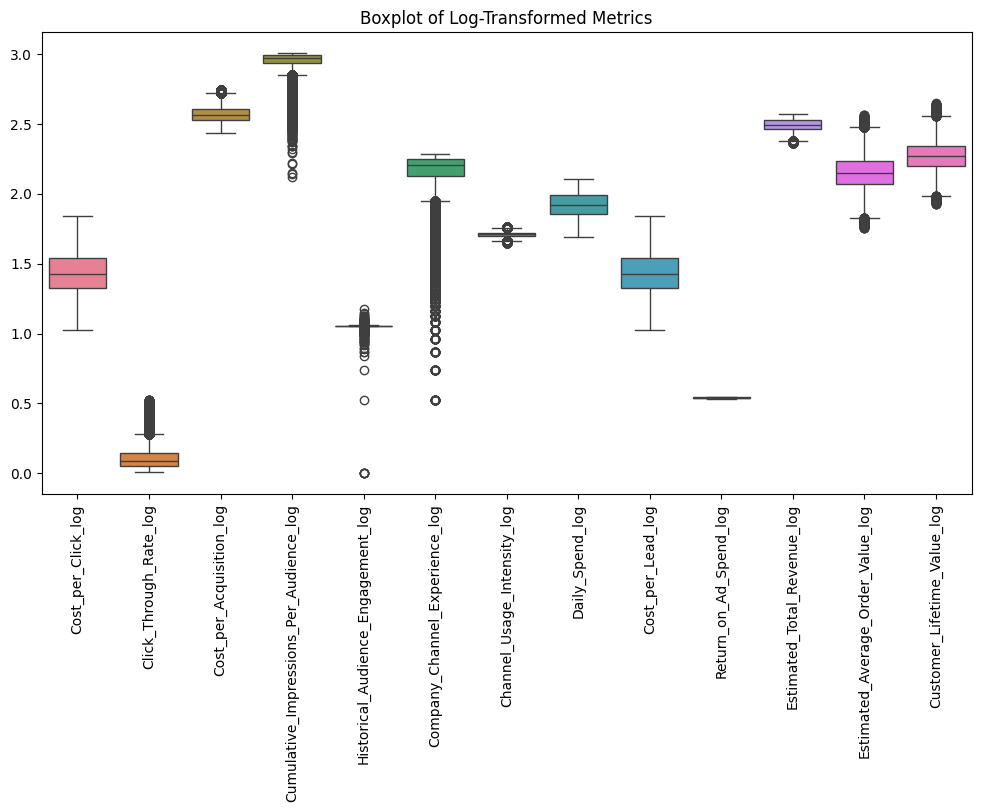


Number of Cost_per_Click_log outliers: 0
Percentage of Cost_per_Click_log outliers: 0.00%

Number of Click_Through_Rate_log outliers: 12152
Percentage of Click_Through_Rate_log outliers: 6.08%

Number of Cost_per_Acquisition_log outliers: 2738
Percentage of Cost_per_Acquisition_log outliers: 1.37%

Number of Cumulative_Impressions_Per_Audience_log outliers: 10700
Percentage of Cumulative_Impressions_Per_Audience_log outliers: 5.35%

Number of Historical_Audience_Engagement_log outliers: 9698
Percentage of Historical_Audience_Engagement_log outliers: 4.85%

Number of Company_Channel_Experience_log outliers: 12120
Percentage of Company_Channel_Experience_log outliers: 6.06%

Number of Channel_Usage_Intensity_log outliers: 1542
Percentage of Channel_Usage_Intensity_log outliers: 0.77%

Number of Daily_Spend_log outliers: 0
Percentage of Daily_Spend_log outliers: 0.00%

Number of Cost_per_Lead_log outliers: 0
Percentage of Cost_per_Lead_log outliers: 0.00%

Number of Return_on_Ad_Spend_lo

C:\Users\R250\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


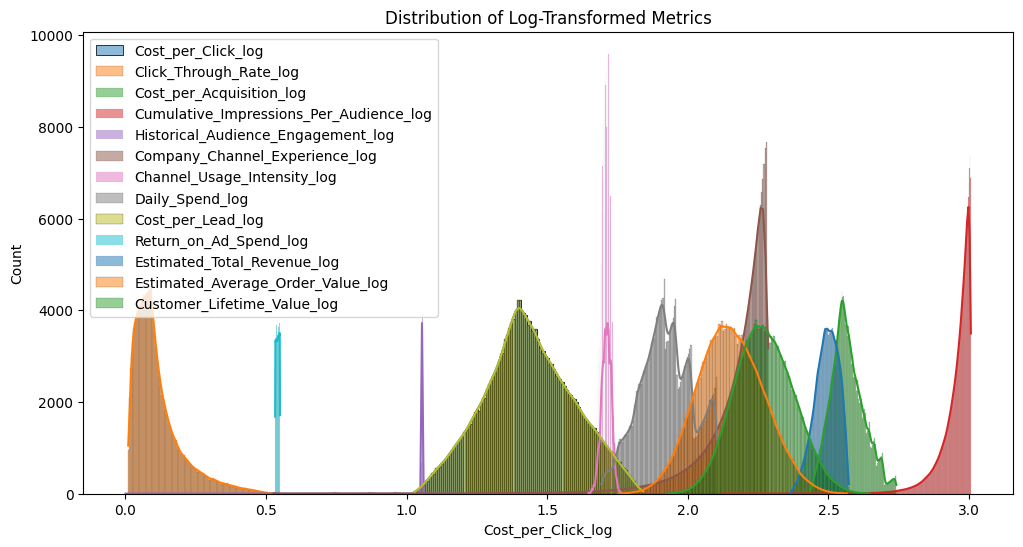

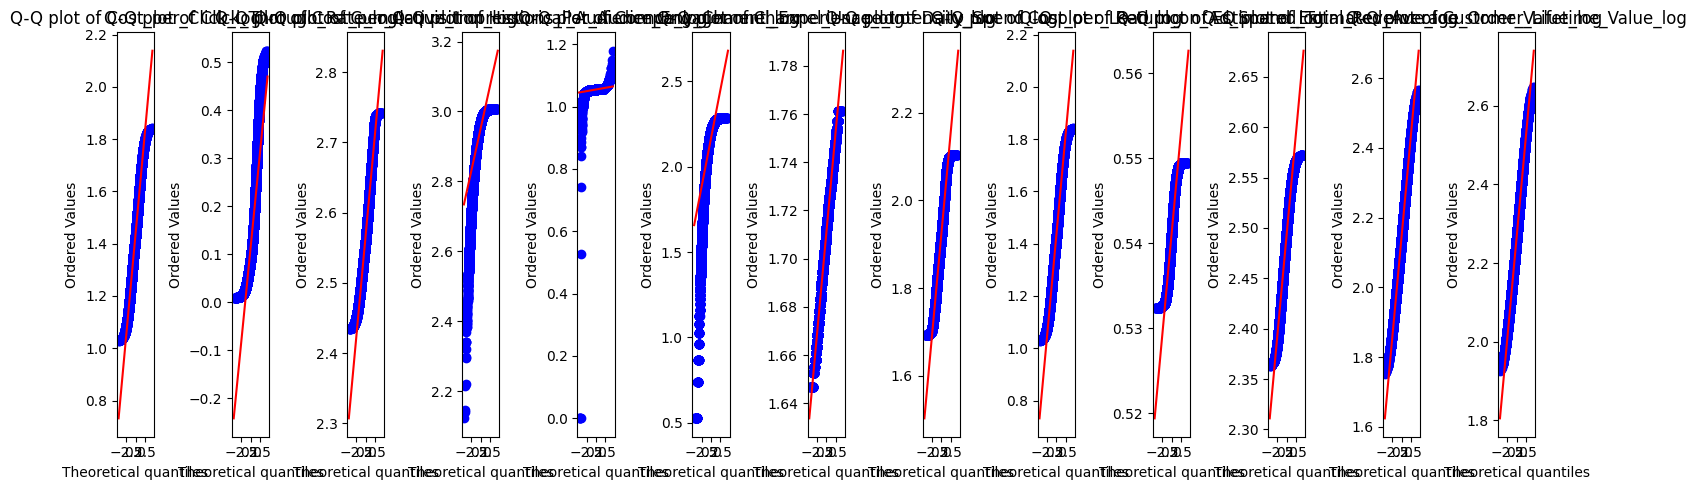

In [17]:
### LOG Transformations 

def log_transform_features(df, features):
    """Apply log transformation to specified features."""
    for feature in features:
        df[f'{feature}_log'] = np.log1p(df[feature])
    return df

def analyze_outliers(df, feature):
    """Analyze outliers for a given feature."""
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    print(f"\nNumber of {feature} outliers: {len(outliers)}")
    print(f"Percentage of {feature} outliers: {len(outliers) / len(df) * 100:.2f}%")

def plot_distributions(df, features):
    """Plot histograms for given features."""
    plt.figure(figsize=(12, 6))
    for feature in features:
        sns.histplot(df[feature], kde=True, label=feature)
    plt.title('Distribution of Log-Transformed Metrics')
    plt.legend()
    plt.show()

def plot_qq(df, features):
    """Create Q-Q plots for given features."""
    fig, axes = plt.subplots(1, len(features), figsize=(15, 5))
    for ax, feature in zip(axes, features):
        stats.probplot(df[feature], dist="norm", plot=ax)
        ax.set_title(f"Q-Q plot of {feature}")
    plt.tight_layout()
    plt.show()

# Main analysis
def main_analysis(df):
    # Define features to analyze (including the new suggestions)
    features = [
        'Cost_per_Click', 'Click_Through_Rate',
       'Cost_per_Acquisition', 'Cumulative_Impressions_Per_Audience',
       'Historical_Audience_Engagement', 'Company_Channel_Experience',
       'Channel_Usage_Intensity', 'Daily_Spend', 'Cost_per_Lead',
       'Return_on_Ad_Spend', 'Estimated_Total_Revenue',
       'Estimated_Average_Order_Value', 'Customer_Lifetime_Value'
    ]
   
    # Log transform features
    df = log_transform_features(df, features)
   
    # Check skewness
    log_features = [f'{feature}_log' for feature in features]
    skewness = df[log_features].skew()
    print("Skewness of Log-transformed features:")
    print(skewness)
   
    # Boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df[log_features])
    plt.title('Boxplot of Log-Transformed Metrics')
    plt.xticks(rotation=90)
    plt.show()
   
    # Analyze outliers
    for feature in log_features:
        analyze_outliers(df, feature)
   
    # Plot distributions
    plot_distributions(df, log_features)
   
    # Q-Q plots
    plot_qq(df, log_features)
    fig.tight_layout(pad=5.0, rect=[0, 0.03, 1, 0.95])
    plt.show()

# Assuming df is your DataFrame
main_analysis(df)


In [6]:
df.columns

Index(['Company', 'Campaign_Type', 'Target_Audience', 'Duration',
       'Channel_Used', 'Conversion_Rate', 'Acquisition_Cost ($)', 'ROI',
       'Location', 'Language', 'Clicks', 'Impressions', 'Engagement_Score',
       'Customer_Segment', 'Date', 'Cost_per_Click', 'Click_Through_Rate',
       'Cost_per_Acquisition', 'Month', 'Day_of_Week', 'Campaign_Start',
       'Days_Since_Campaign_Start', 'Cumulative_Impressions_Per_Audience',
       'Historical_Audience_Engagement', 'Company_Channel_Experience',
       'Channel_Usage_Intensity', 'Daily_Spend', 'Cost_per_Lead',
       'Return_on_Ad_Spend', 'Estimated_Total_Revenue',
       'Estimated_Average_Order_Value', 'Customer_Lifetime_Value',
       'Duration_Category', 'Cost_per_Click_log', 'Click_Through_Rate_log',
       'Cost_per_Acquisition_log', 'Cumulative_Impressions_Per_Audience_log',
       'Historical_Audience_Engagement_log', 'Company_Channel_Experience_log',
       'Channel_Usage_Intensity_log', 'Daily_Spend_log', 'Cost_per_Le

In [7]:
# List of columns to rename
columns_to_rename = [
    'Cost_per_Click_log', 'Click_Through_Rate_log', 'Cost_per_Acquisition_log', 
    'Cost_per_Lead_log', 'Estimated_Average_Order_Value_log', 'Customer_Lifetime_Value_log', 
    'Daily_Spend_log', 'Estimated_Total_Revenue_log',
    'Cumulative_Impressions_Per_Audience_log', 'Historical_Audience_Engagement_log', 
    'Company_Channel_Experience_log', 'Channel_Usage_Intensity_log', 'Return_on_Ad_Spend_log'
]

# Rename columns
for column in columns_to_rename:
    new_column_name = column.replace('_log', '')
    df[new_column_name] = df[column]

# List of columns to drop
columns_to_drop = columns_to_rename

# Drop the original log-transformed columns
df = df.drop(columns=columns_to_drop)

# Print the column names to verify
print(df.columns)

Index(['Company', 'Campaign_Type', 'Target_Audience', 'Duration',
       'Channel_Used', 'Conversion_Rate', 'Acquisition_Cost ($)', 'ROI',
       'Location', 'Language', 'Clicks', 'Impressions', 'Engagement_Score',
       'Customer_Segment', 'Date', 'Cost_per_Click', 'Click_Through_Rate',
       'Cost_per_Acquisition', 'Month', 'Day_of_Week', 'Campaign_Start',
       'Days_Since_Campaign_Start', 'Cumulative_Impressions_Per_Audience',
       'Historical_Audience_Engagement', 'Company_Channel_Experience',
       'Channel_Usage_Intensity', 'Daily_Spend', 'Cost_per_Lead',
       'Return_on_Ad_Spend', 'Estimated_Total_Revenue',
       'Estimated_Average_Order_Value', 'Customer_Lifetime_Value',
       'Duration_Category'],
      dtype='object')


#### Preprocessing the data


In [18]:
def preprocess_data(df, target='ROI', vif_threshold=10):
    """
    Preprocess the data for machine learning models.
    
    Parameters:
    df (pd.DataFrame): Input dataframe
    target (str): Target variable name
    vif_threshold (float): Threshold for VIF in multicollinearity check
    
    Returns:
    X_scaled (pd.DataFrame): Scaled features
    y (pd.Series): Target variable
    """
    features = [
        'Conversion_Rate', 'Clicks', 'Impressions', 'Engagement_Score',
        'Cost_per_Click', 'Click_Through_Rate',
        'Cost_per_Acquisition', 'Days_Since_Campaign_Start',
        'Cumulative_Impressions_Per_Audience', 'Company_Channel_Experience',  
        'Month', 'Day_of_Week',
        'Days_Since_Campaign_Start', 'Cumulative_Impressions_Per_Audience',
        'Historical_Audience_Engagement', 'Company_Channel_Experience',
        'Channel_Usage_Intensity', 'Daily_Spend',
        'Cost_per_Lead', 'Return_on_Ad_Spend', 'Estimated_Total_Revenue',
        'Estimated_Average_Order_Value', 'Customer_Lifetime_Value'
    ]
    
    X = df[features]
    y = df[target]
    
    # Handle missing values
    X = X.fillna(X.median())
    
    # Convert all columns to numeric, dropping non-numeric columns
    X = X.apply(pd.to_numeric, errors='coerce')
    X = X.dropna(axis=1)
    
    # Check for multicollinearity
    X = handle_multicollinearity(X, threshold=vif_threshold)
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
    
    return X_scaled, y

def handle_multicollinearity(X, threshold=10):
    """
    Handle multicollinearity by removing features with high VIF.
    
    Parameters:
    X (pd.DataFrame): Input features
    threshold (float): VIF threshold for feature removal
    
    Returns:
    X (pd.DataFrame): Features with high VIF removed
    """
    vif = pd.DataFrame()
    vif["feature"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    high_vif_features = vif[vif["VIF"] > threshold]["feature"].tolist()
    if high_vif_features:
        print(f"Removing high VIF features: {high_vif_features}")
        X = X.drop(columns=high_vif_features)
    else:
        print("No high VIF features found.")
    
    return X

### Usage
X_scaled, y = preprocess_data(df)
print("Preprocessed features:", X_scaled.columns)
print("Target variable:", y.name)

c:\Users\R250\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing high VIF features: ['Conversion_Rate', 'Clicks', 'Impressions', 'Cost_per_Click', 'Cost_per_Acquisition', 'Days_Since_Campaign_Start', 'Cumulative_Impressions_Per_Audience', 'Company_Channel_Experience', 'Month', 'Days_Since_Campaign_Start', 'Cumulative_Impressions_Per_Audience', 'Historical_Audience_Engagement', 'Company_Channel_Experience', 'Channel_Usage_Intensity', 'Daily_Spend', 'Cost_per_Lead', 'Return_on_Ad_Spend', 'Estimated_Total_Revenue', 'Estimated_Average_Order_Value', 'Customer_Lifetime_Value']
Preprocessed features: Index(['Engagement_Score', 'Click_Through_Rate', 'Day_of_Week'], dtype='object')
Target variable: ROI


Encoding Categorical Features for Statistical Analysis

In [19]:

def encode_categorical(df, columns):
    le = LabelEncoder()
    for col in columns:
        df[f'{col}'] = le.fit_transform(df[col])
    return df

# Encode categorical variables
categorical_columns = ['Duration','Company', 'Campaign_Type', 'Target_Audience', 'Channel_Used', 'Location', 'Language', 'Customer_Segment','Duration_Category']
df = encode_categorical(df, categorical_columns)


#### Preprocessing the data and Selecting features for analysis

In [20]:
# Select features for analysis
features = [
    'Campaign_Type', 'Target_Audience', 'Duration',
       'Channel_Used', 'Conversion_Rate', 'Acquisition_Cost ($)',
       'Location', 'Language', 'Clicks', 'Impressions', 'Engagement_Score',
       'Customer_Segment', 'Cost_per_Click', 'Click_Through_Rate',
       'Cost_per_Acquisition','Cumulative_Impressions_Per_Audience',
       'Historical_Audience_Engagement', 'Company_Channel_Experience',
       'Channel_Usage_Intensity', 'Daily_Spend', 'Cost_per_Lead',
       'Estimated_Average_Order_Value', 'Customer_Lifetime_Value',
       'Duration_Category'
]

X = df[features]
y = df['ROI']
    
    # Handle missing values
X = X.fillna(X.median())

Normalize and split data

In [21]:
# Normalize the data
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

Principal Component Analysis

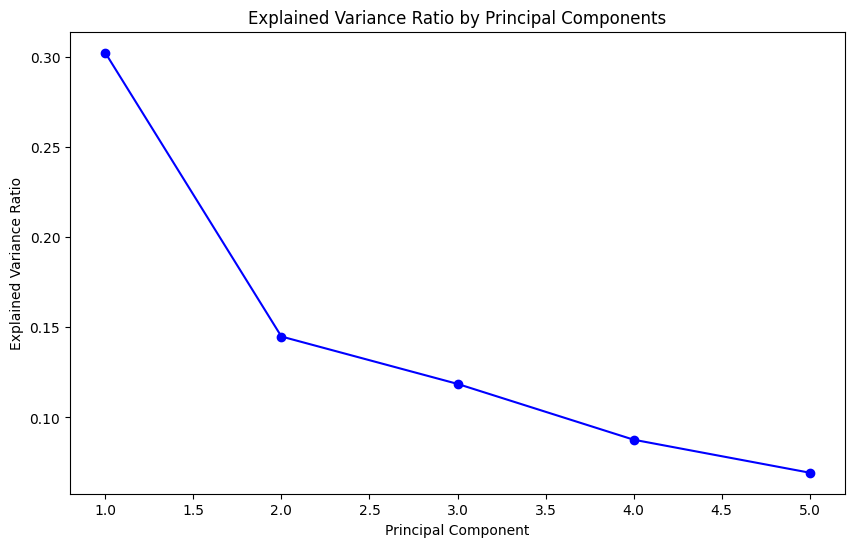

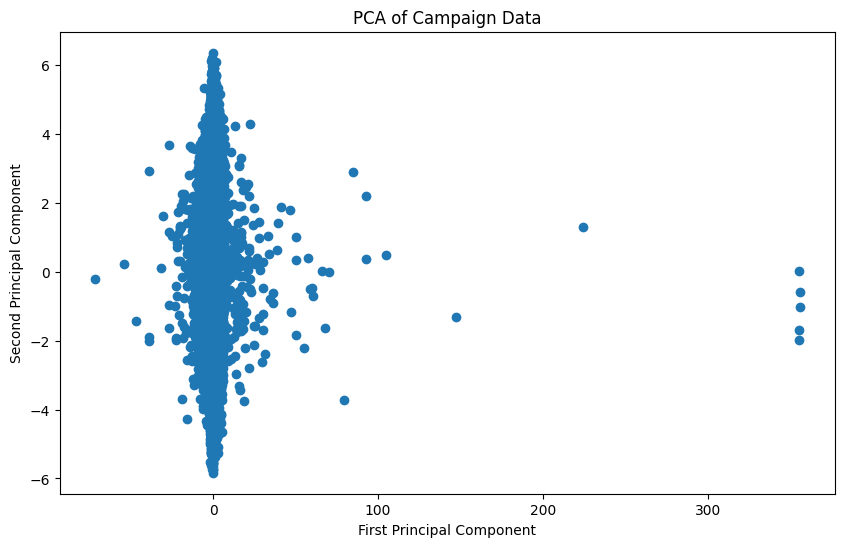

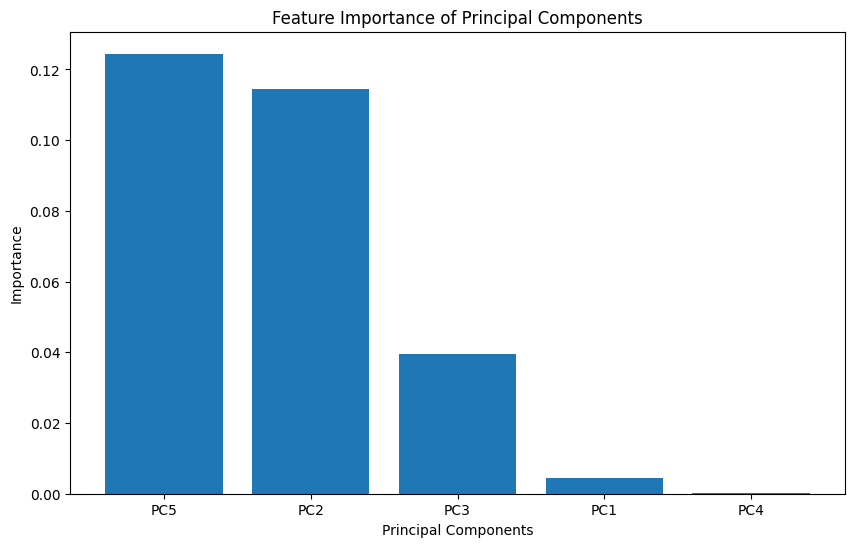

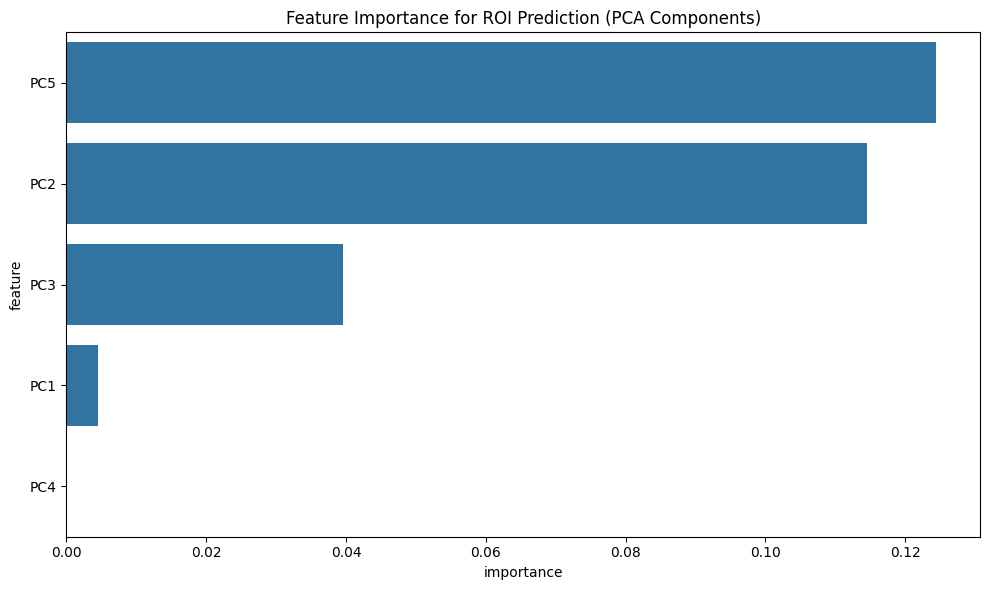

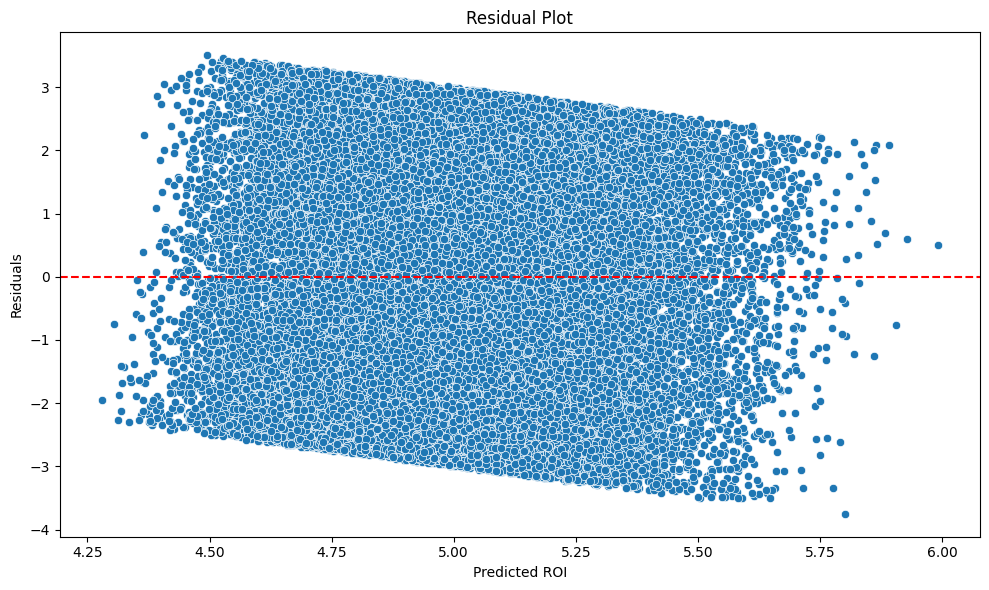

Mean Squared Error: 2.95427269243736
R-squared Score: 0.019078385245550056


In [11]:
# Perform PCA
def perform_pca(X_scaled, n_components=5):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    # Plot explained variance ratio
    plt.figure(figsize=(10,6))
    plt.plot(range(1, n_components+1), pca.explained_variance_ratio_, 'bo-')
    plt.title('Explained Variance Ratio by Principal Components')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.show()
    
    # Plot PCA
    plt.figure(figsize=(10,6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1])
    plt.title('PCA of Campaign Data')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()
    
    return X_pca, pca

# Perform PCA
n_components = 5  # You can adjust this number
X_pca, pca = perform_pca(X_scaled, n_components)

model = LinearRegression()

# Fit the model
model.fit(X_pca, y)

# Compute feature importance based on coefficients
feature_importance = pd.DataFrame({
    'feature': [f'PC{i+1}' for i in range(X_pca.shape[1])],
    'importance': abs(model.coef_)
})

# Sort by importance
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Principal Components')
plt.ylabel('Importance')
plt.title('Feature Importance of Principal Components')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance for ROI Prediction (PCA Components)')
plt.tight_layout()
plt.show()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted ROI')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

#### eda

1. Basic Statistical Summary
             Company  Campaign_Type  Target_Audience       Duration  \
count  200000.000000  200000.000000    200000.000000  200000.000000   
mean        2.001755       1.999735         1.995455       1.500265   
min         0.000000       0.000000         0.000000       0.000000   
25%         1.000000       1.000000         1.000000       1.000000   
50%         2.000000       2.000000         2.000000       1.000000   
75%         3.000000       3.000000         3.000000       2.000000   
max         4.000000       4.000000         4.000000       3.000000   
std         1.416256       1.412878         1.412609       1.116448   

        Channel_Used  Conversion_Rate  Acquisition_Cost ($)            ROI  \
count  200000.000000    200000.000000         200000.000000  200000.000000   
mean        2.501355         0.080070          12504.393040       5.002438   
min         0.000000         0.010000           5000.000000       2.000000   
25%         1.00000

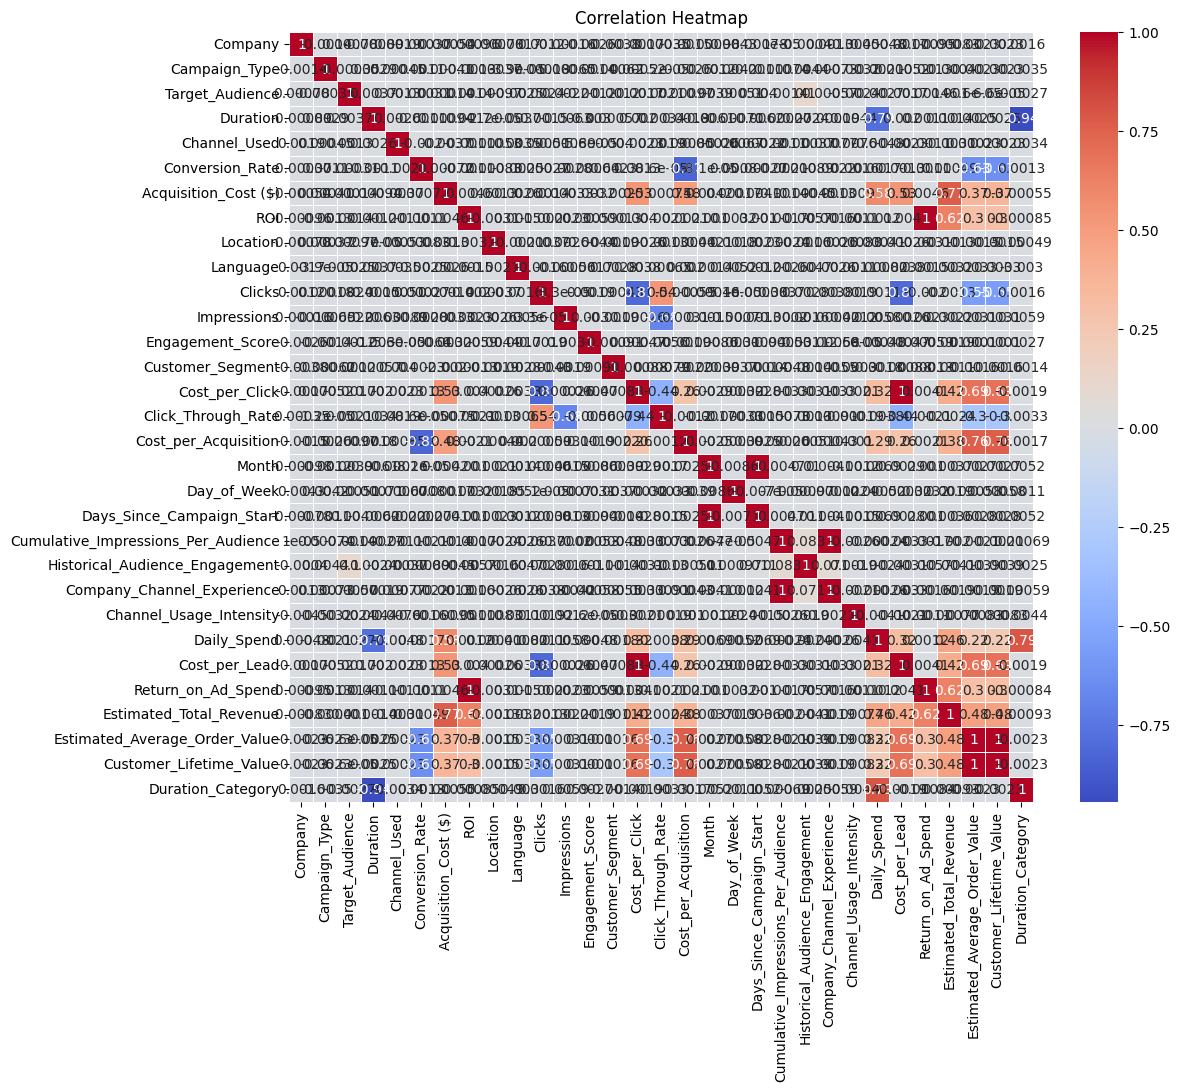


3. Campaign Type Analysis


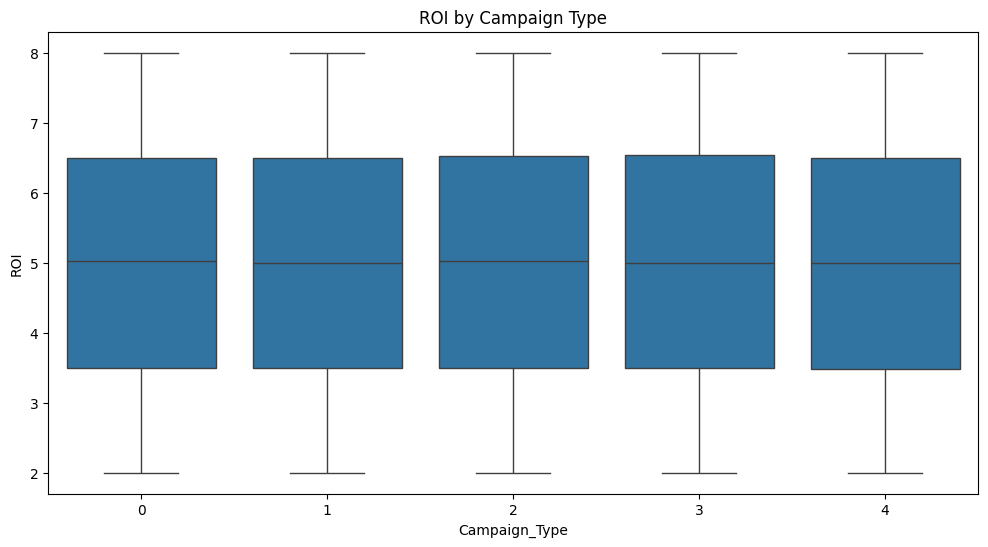

ANOVA test for ROI across Campaign Types:
F-statistic: 1.017014238141116, p-value: 0.3968764882167651

4. Channel Analysis


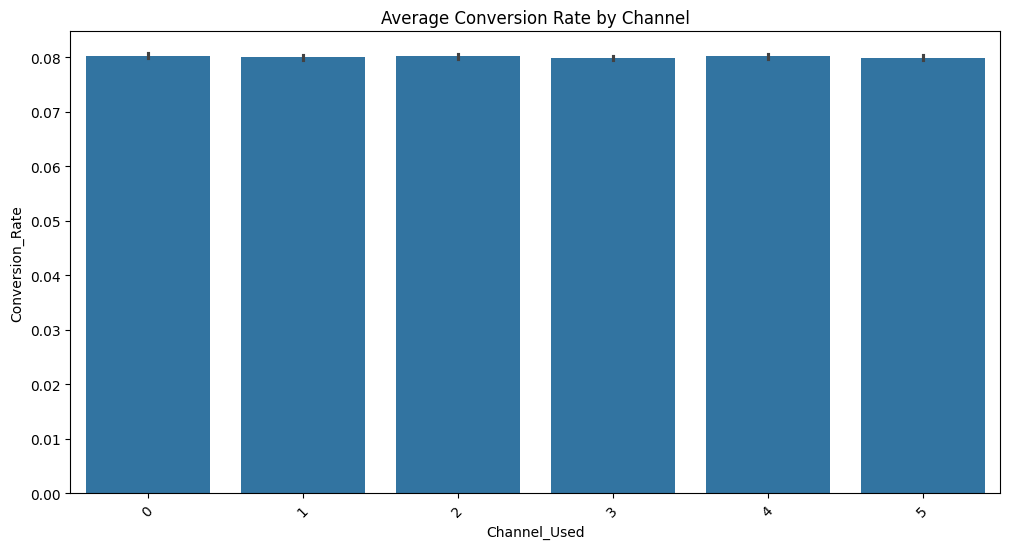

Chi-Square test for Channel Used and Campaign Type:
Chi-Square statistic: 17.361229536702766, p-value: 0.6294082578084719

5. Time Series Analysis


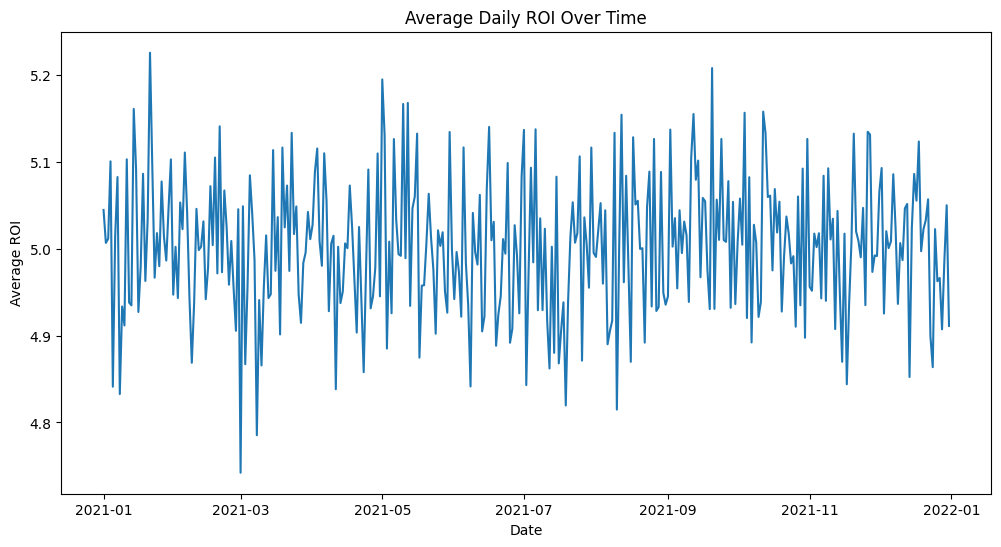


6. Customer Segment Analysis


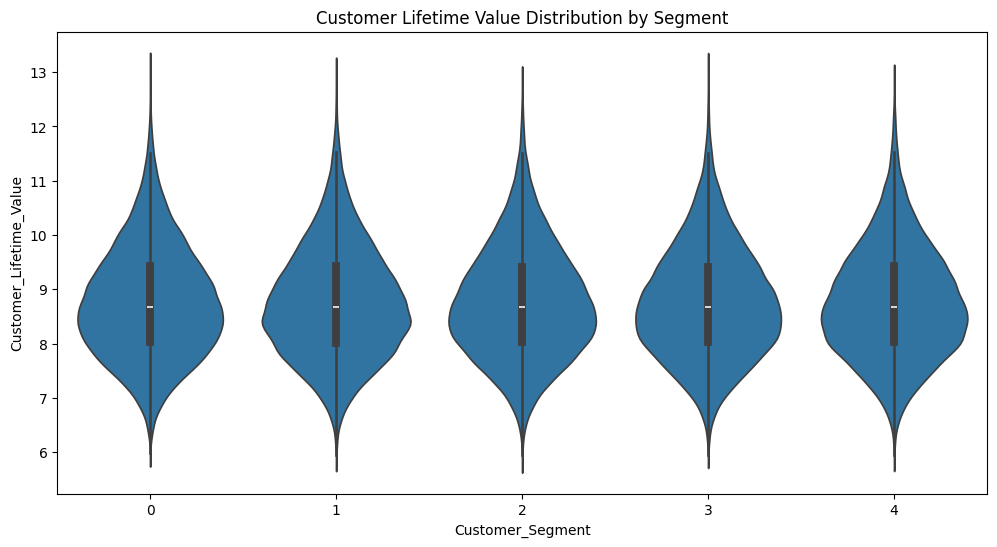


7. Multiple Linear Regression
                            OLS Regression Results                            
Dep. Variable:                    ROI   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.065
Date:                Thu, 05 Sep 2024   Prob (F-statistic):              0.381
Time:                        02:33:32   Log-Likelihood:            -3.9393e+05
No. Observations:              200000   AIC:                         7.879e+05
Df Residuals:                  199993   BIC:                         7.879e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
c

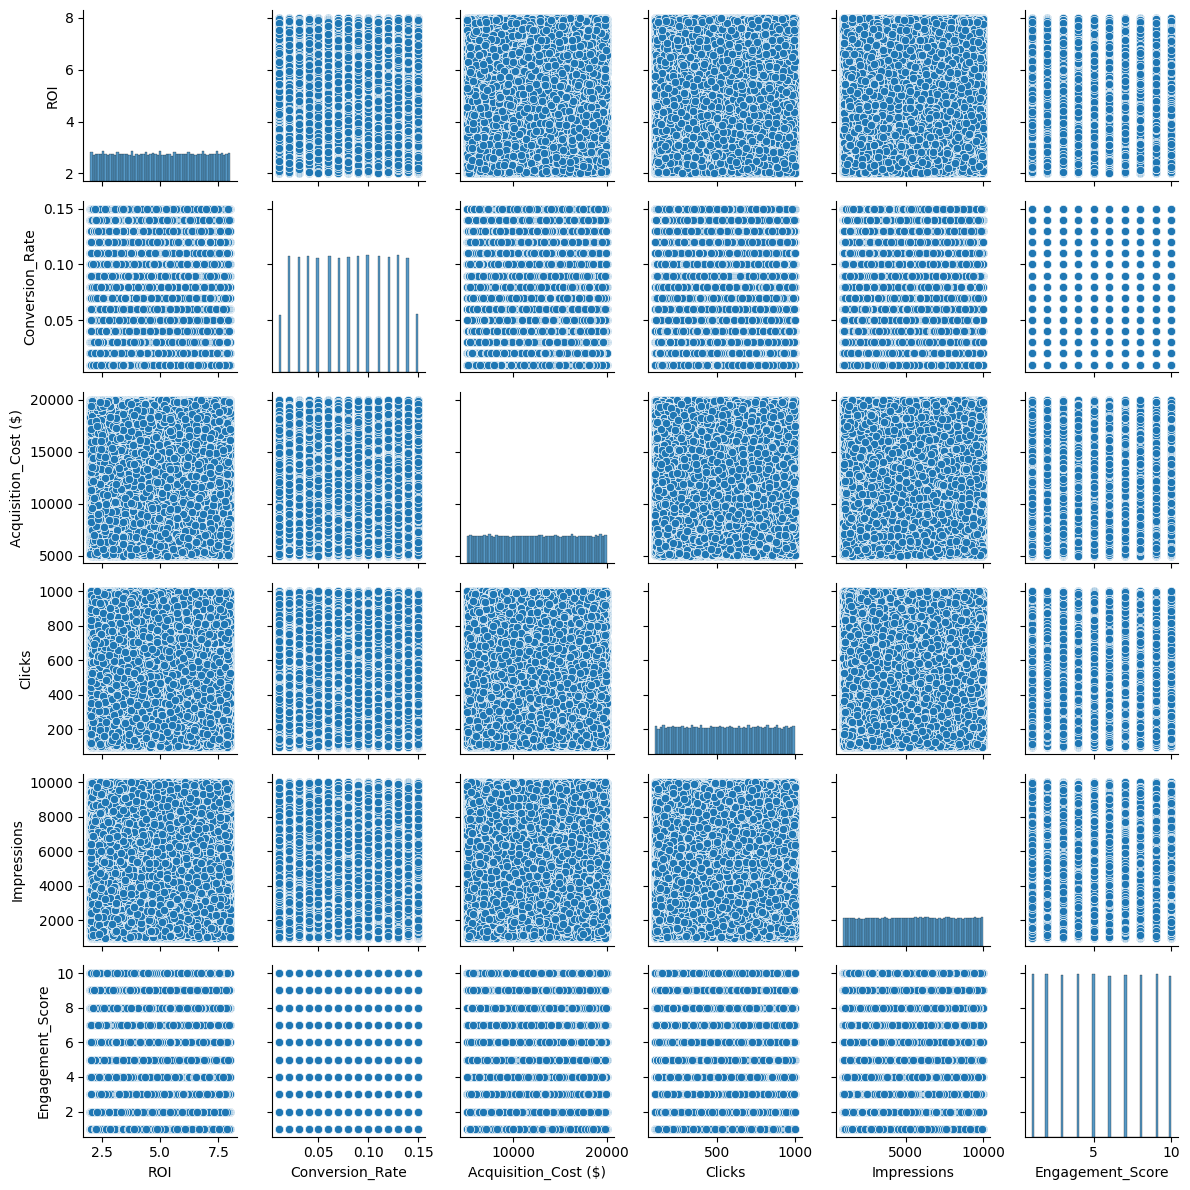

In [12]:

# 1. Basic Statistical Summary
def basic_stats(df):
    print(df.describe())
    print("\nData Types:")
    print(df.dtypes)
    print("\nMissing Values:")
    print(df.isnull().sum())

# 2. Correlation Analysis
def correlation_analysis(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    corr = df[numeric_cols].corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Heatmap')
    plt.show()

# 3. Campaign Type Analysis
def campaign_type_analysis(df):
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Campaign_Type', y='ROI', data=df)
    plt.title('ROI by Campaign Type')
    plt.show()
    
    anova = stats.f_oneway(*[group['ROI'].values for name, group in df.groupby('Campaign_Type')])
    print("ANOVA test for ROI across Campaign Types:")
    print(f"F-statistic: {anova.statistic}, p-value: {anova.pvalue}")

# 4. Channel Analysis
def channel_analysis(df):
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Channel_Used', y='Conversion_Rate', data=df)
    plt.title('Average Conversion Rate by Channel')
    plt.xticks(rotation=45)
    plt.show()

    chi2, p, dof, expected = stats.chi2_contingency(pd.crosstab(df['Channel_Used'], df['Campaign_Type']))
    print("Chi-Square test for Channel Used and Campaign Type:")
    print(f"Chi-Square statistic: {chi2}, p-value: {p}")

# 5. Time Series Analysis
def time_series_analysis(df):
    df['Date'] = pd.to_datetime(df['Date'])
    daily_data = df.groupby('Date')['ROI'].mean().reset_index()
    plt.figure(figsize=(12, 6))
    plt.plot(daily_data['Date'], daily_data['ROI'])
    plt.title('Average Daily ROI Over Time')
    plt.xlabel('Date')
    plt.ylabel('Average ROI')
    plt.show()

# 6. Customer Segment Analysis
def customer_segment_analysis(df):
    plt.figure(figsize=(12, 6))
    sns.violinplot(x='Customer_Segment', y='Customer_Lifetime_Value', data=df)
    plt.title('Customer Lifetime Value Distribution by Segment')
    plt.show()

# 7. Multiple Linear Regression
def multiple_linear_regression(df):
    features = ['Conversion_Rate', 'Acquisition_Cost ($)', 'Clicks', 'Impressions', 'Engagement_Score', 'Cost_per_Click']
    X = sm.add_constant(df[features])
    y = df['ROI']
    model = sm.OLS(y, X).fit()
    print(model.summary())

# 8. Scatter Plot Matrix
def scatter_plot_matrix(df):
    features = ['ROI', 'Conversion_Rate', 'Acquisition_Cost ($)', 'Clicks', 'Impressions', 'Engagement_Score']
    sns.pairplot(df[features], height=2)
    plt.tight_layout()
    plt.show()

# Main analysis function
def analyze_marketing_data(df):
    print("1. Basic Statistical Summary")
    basic_stats(df)
    
    print("\n2. Correlation Analysis")
    correlation_analysis(df)
    
    print("\n3. Campaign Type Analysis")
    campaign_type_analysis(df)
    
    print("\n4. Channel Analysis")
    channel_analysis(df)
    
    print("\n5. Time Series Analysis")
    time_series_analysis(df)
    
    print("\n6. Customer Segment Analysis")
    customer_segment_analysis(df)
    
    print("\n7. Multiple Linear Regression")
    multiple_linear_regression(df)
    
    print("\n8. Scatter Plot Matrix")
    scatter_plot_matrix(df)

# Run the analysis
analyze_marketing_data(df)


Main pipeline

Mean Squared Error: 0.24448836521958373
Mean Absolute Error: 0.35513143511446543
R-squared Score: 0.9188213320274073


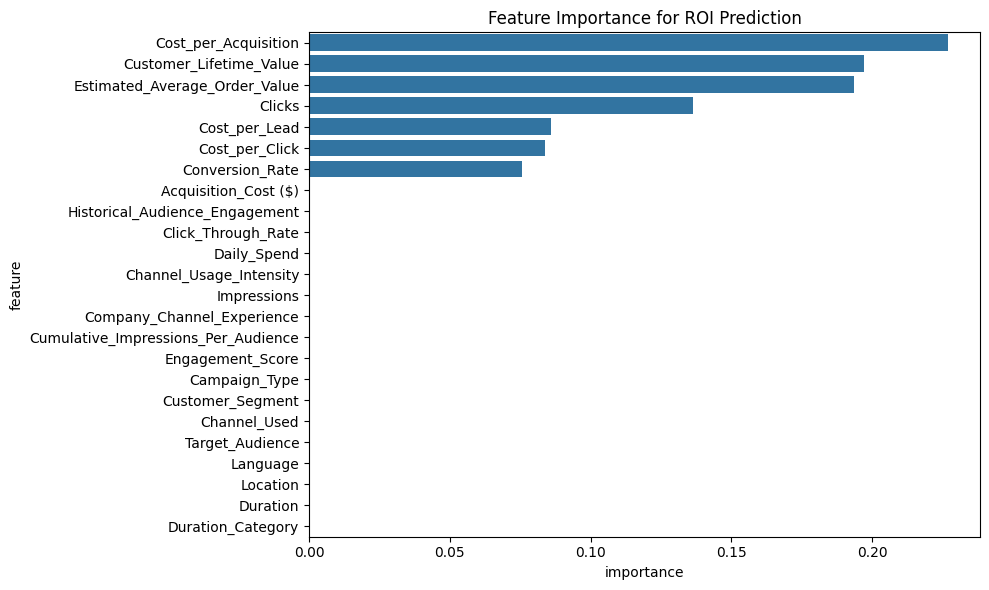

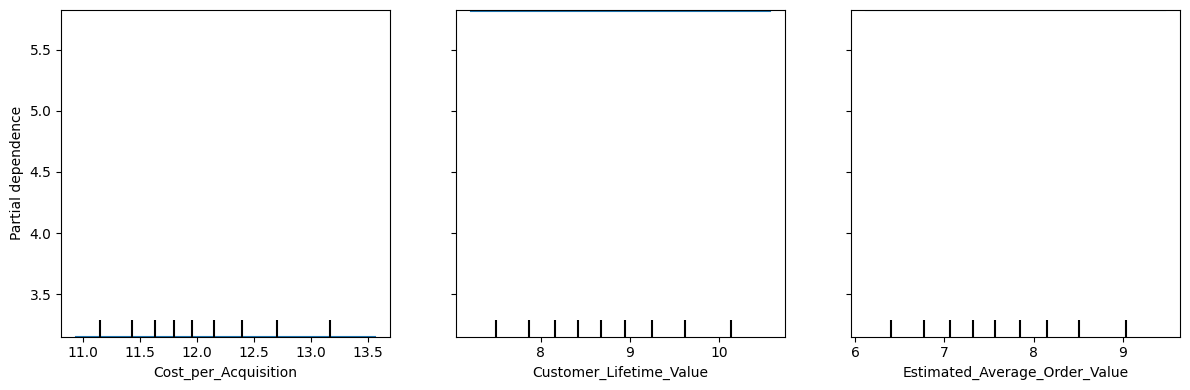

In [13]:

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute missing values and scale features
imputer = SimpleImputer(strategy='median')
scaler = RobustScaler()

X_train_processed = scaler.fit_transform(imputer.fit_transform(X_train))
X_test_processed = scaler.transform(imputer.transform(X_test))

# Create and train the model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)
rf_model.fit(X_train_processed, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_processed)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared Score: {r2}")

# Feature importance
feature_importance = pd.DataFrame({'feature': features, 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance for ROI Prediction')
plt.tight_layout()
plt.show()

# Partial dependence plots for top 3 features
top_features = feature_importance['feature'].head(3).tolist()
fig, ax = plt.subplots(figsize=(12, 4))
PartialDependenceDisplay.from_estimator(rf_model, X_train, features=top_features, ax=ax)
plt.tight_layout()
plt.show()

preprocessing the ml data

Training R^2 Score: 0.9588382418403634
Test R^2 Score: 0.9590435331553998


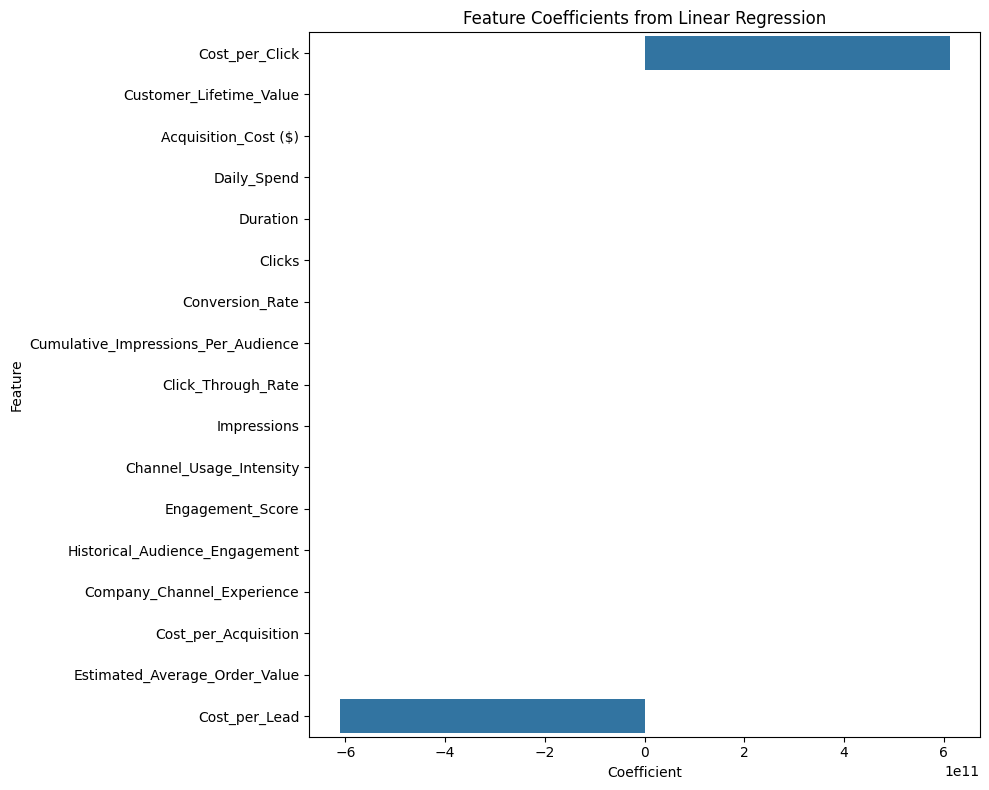

                                Feature   Coefficient
6                        Cost_per_Click  6.116399e+11
16              Customer_Lifetime_Value  1.722228e+02
2                  Acquisition_Cost ($)  1.203346e+00
13                          Daily_Spend  7.416203e-01
0                              Duration  5.871114e-01
3                                Clicks  3.992001e-01
1                       Conversion_Rate  2.021994e-01
9   Cumulative_Impressions_Per_Audience  5.179701e-03
7                    Click_Through_Rate  4.817349e-03
4                           Impressions  2.319766e-03
12              Channel_Usage_Intensity  3.006184e-04
5                      Engagement_Score  1.394242e-05
10       Historical_Audience_Engagement -8.450151e-04
11           Company_Channel_Experience -6.006114e-03
8                  Cost_per_Acquisition -3.970564e+00
15        Estimated_Average_Order_Value -1.666718e+02
14                        Cost_per_Lead -6.116399e+11


In [14]:

def preprocess_data(df):
    """
    Preprocess the dataset for machine learning models.

    Args:
    df (pd.DataFrame): The input dataframe.

    Returns:
    X_train (pd.DataFrame): The training set features.
    X_test (pd.DataFrame): The test set features.
    y_train (pd.Series): The training set target.
    y_test (pd.Series): The test set target.
    preprocessor (ColumnTransformer): The preprocessor used to transform the data.
    """
    # Prepare the data
    X = df[features]
    y = df['ROI']

    # Define numerical and categorical columns
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns

    # Preprocessing for numerical data
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Preprocessing for categorical data
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test, preprocessor

def train_linear_regression(X_train, y_train, preprocessor):
    """
    Train a linear regression model.

    Args:
    X_train (pd.DataFrame): The training set features.
    y_train (pd.Series): The training set target.
    preprocessor (ColumnTransformer): The preprocessor used to transform the data.

    Returns:
    model (Pipeline): The trained linear regression model.
    """
    # Create preprocessing and training pipeline
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', LinearRegression())])

    # Fit the model
    model.fit(X_train, y_train)

    return model

def evaluate_model(model, X_train, X_test, y_train, y_test):
    """
    Evaluate the model on training and test data.

    Args:
    model (Pipeline): The trained model.
    X_train (pd.DataFrame): The training set features.
    X_test (pd.DataFrame): The test set features.
    y_train (pd.Series): The training set target.
    y_test (pd.Series): The test set target.
    """
    # Evaluate the model
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    print(f"Training R^2 Score: {train_score}")
    print(f"Test R^2 Score: {test_score}")

def check_feature_importance(model, X_train):
    """
    Check feature importance based on model coefficients.

    Args:
    model (Pipeline): The trained model.
    X_train (pd.DataFrame): The training set features.

    Returns:
    feature_importance_df (pd.DataFrame): DataFrame of feature importances.
    """
    # Fit the preprocessor to the training data
    preprocessor = model.named_steps['preprocessor']
    X_train_transformed = preprocessor.transform(X_train)
    
    # Extract feature names after preprocessing
    feature_names = np.concatenate([
        X_train.select_dtypes(include=['int64', 'float64']).columns,
        ])
    
    # Get model coefficients
    coefficients = model.named_steps['regressor'].coef_

    # Create a DataFrame for feature importances
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
    feature_importance_df = feature_importance_df.sort_values(by='Coefficient', ascending=False)
    
    # Plot the feature importances
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Coefficient', y='Feature', data=feature_importance_df)
    plt.title('Feature Coefficients from Linear Regression')
    plt.tight_layout()
    plt.show()
    
    print(feature_importance_df)
    return feature_importance_df

# Main workflow 
# Preprocess the data
X_train, X_test, y_train, y_test, preprocessor = preprocess_data(df)

# Train the Linear Regression model
linear_model = train_linear_regression(X_train, y_train, preprocessor)

# Evaluate the Linear Regression model
evaluate_model(linear_model, X_train, X_test, y_train, y_test)

# Check feature importance
feature_importance_df = check_feature_importance(linear_model, X_train)


Experiment 1: Using PCA
Cross-validated R^2 Score: 0.124 ± 0.002
Cross-validated RMSE: 1.623 ± 0.002
Test Set Mean Squared Error: 2.637
Test Set Mean Absolute Error: 1.379
Test Set RMSE: 1.624
Test Set R-squared Score: 0.124
Cross-validated R^2 Score: 0.180 ± 0.001
Cross-validated RMSE: 1.571 ± 0.001
Test Set Mean Squared Error: 2.464
Test Set Mean Absolute Error: 1.318
Test Set RMSE: 1.570
Test Set R-squared Score: 0.182
Cross-validated R^2 Score: 0.180 ± 0.001
Cross-validated RMSE: 1.571 ± 0.001
Test Set Mean Squared Error: 2.464
Test Set Mean Absolute Error: 1.318
Test Set RMSE: 1.570
Test Set R-squared Score: 0.182

Experiment 2: Using Raw Features
Cross-validated R^2 Score: 0.188 ± 0.002
Cross-validated RMSE: 1.563 ± 0.003
Test Set Mean Squared Error: 2.452
Test Set Mean Absolute Error: 1.315
Test Set RMSE: 1.566
Test Set R-squared Score: 0.186
Cross-validated R^2 Score: 0.295 ± 0.001
Cross-validated RMSE: 1.456 ± 0.002
Test Set Mean Squared Error: 2.118
Test Set Mean Absolute Err

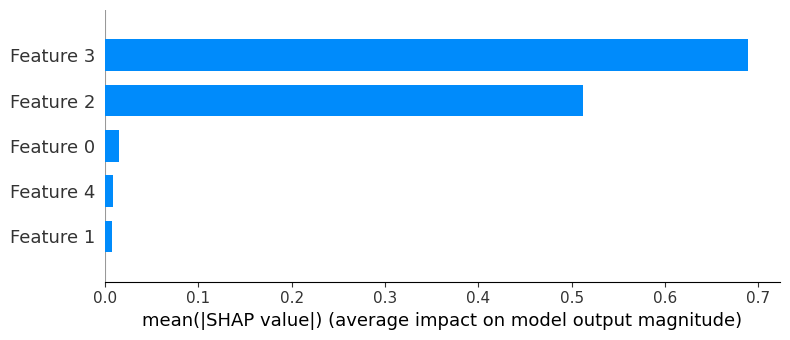

In [15]:
# Main Pipeline
# Feature selection
selector = SelectKBest(f_regression, k=5)
X_selected = selector.fit_transform(X, y)
selected_features = [features[i] for i in selector.get_support(indices=True)]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Preprocess the data
imputer = SimpleImputer(strategy='median')
scaler = RobustScaler()
X_train_processed = scaler.fit_transform(imputer.fit_transform(X_train))
X_test_processed = scaler.transform(imputer.transform(X_test))

# K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_model_cv(model, X_train, y_train, X_test, y_test, cv):
    # Cross-validated scores
    r2_cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2', n_jobs=-1)
    mse_cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    rmse_cv_scores = np.sqrt(-mse_cv_scores)
   
    # Fit the model on full training data
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Evaluate on test set
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Cross-validated R^2 Score: {r2_cv_scores.mean():.3f} ± {r2_cv_scores.std():.3f}")
    print(f"Cross-validated RMSE: {rmse_cv_scores.mean():.3f} ± {rmse_cv_scores.std():.3f}")
    print(f"Test Set Mean Squared Error: {mse:.3f}")
    print(f"Test Set Mean Absolute Error: {mae:.3f}")
    print(f"Test Set RMSE: {rmse:.3f}")
    print(f"Test Set R-squared Score: {r2:.3f}")
    
    return model

# SHAP analysis function
def perform_shap_analysis(model, X):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X, plot_type="bar", show=False)
    print("SHAP analysis completed. Please check the generated plot.")

# Experiment 1: Using PCA
print("Experiment 1: Using PCA")
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train_processed)
X_test_pca = pca.transform(X_test_processed)

# Linear Regression with PCA
lr_pca = LinearRegression()
lr_pca = evaluate_model_cv(lr_pca, X_train_pca, y_train, X_test_pca, y_test, cv=kf)

# Random Forest with PCA
rf_pca = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=2, random_state=42, n_jobs=-1)
rf_pca = evaluate_model_cv(rf_pca, X_train_pca, y_train, X_test_pca, y_test, cv=kf)

# XGBoost with PCA
xgb_pca = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb_pca = evaluate_model_cv(xgb_pca, X_train_pca, y_train, X_test_pca, y_test, cv=kf)

# Experiment 2: Using Raw Features
print("\nExperiment 2: Using Raw Features")

# Linear Regression with raw features
lr_raw = LinearRegression()
lr_raw = evaluate_model_cv(lr_raw, X_train_processed, y_train, X_test_processed, y_test, cv=kf)

# Random Forest with raw features
rf_raw = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=2, random_state=42, n_jobs=-1)
rf_raw = evaluate_model_cv(rf_raw, X_train_processed, y_train, X_test_processed, y_test, cv=kf)

# XGBoost with raw features
xgb_raw = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb_raw = evaluate_model_cv(xgb_raw, X_train_processed, y_train, X_test_processed, y_test, cv=kf)

# Perform SHAP analysis on the best performing model (assuming it's XGBoost with raw features)
print("\nPerforming SHAP analysis on XGBoost model with raw features")
perform_shap_analysis(xgb_raw, X_test_processed)